In [1]:
import seaborn as sns
from ydata_synthetic.synthesizers.timeseries import TimeGAN
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
import pandas as pd
import numpy as np
import os
import pickle
import sys
sys.path.insert(0, '../../data_process/')
sys.path.insert(1, '../')
from create_plots import *
import params

2024-04-05 14:14:55.795342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 14:14:55.866043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local//cuda-11.8/lib64
2024-04-05 14:14:55.866056: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-05 14:14:56.236613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shar

In [2]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def fatNum(N):
    # Find the closest possible factor to N^(1/3) to balance i, j and k
    closest_cube_root = round(N ** (1/3))

    # Find the closest factors starting from the approximate cube root
    for i in range(closest_cube_root, 0, -1):
        if N % i == 0:
            # N/i is now the product of j * k
            remaining = N // i
            for j in range(int(remaining ** 0.5), 0, -1):
                if remaining % j == 0:
                    k = remaining // j
                    return i, j, k  # Returns factors as soon as they are found

    return None  # Returns None if factoring is not possible

In [4]:
def defact(index):
    #  iMax, jMax, kMax = fatNum(params.amount_of_models) 
    #  for i in range(0,iMax):
    #     for j in range(0,jMax):
    #         for k in range(0,kMax):
    #             if( (i*iMax) + (j*jMax) + (k) == index ):
    #                return i, j, k
                
    iMax, jMax, kMax = fatNum(params.amount_of_models)

    # Calcular i, j, e k diretamente
    i = index // (jMax * kMax)
    j = (index % (jMax * kMax)) // kMax
    k = index % kMax

    return i, j, k

In [5]:
def getBestWorstAllFeatures(models, data_metrics, sample_size, num_cols):
    best_32 = np.zeros(sample_size*14).reshape(sample_size, 14)
    worst_32 = np.zeros(sample_size*14).reshape(sample_size, 14)
    best_64 = np.zeros(sample_size*14).reshape(sample_size, 14)
    worst_64 = np.zeros(sample_size*14).reshape(sample_size, 14)

    for j, col in enumerate(num_cols): 
        x = data_metrics[0,:,j]
        index = np.where(x == x.min())[0][0]
        i, y, k = fatNum(index)
        model = 'so_seqlen_'+ str((50*(i) + 50)) + '_hidim_' + str(20*(y)+20) + '_batch_' +  str(28*(k) + 100) + '.pkl'
        best_32[:,j] = models.get(model)[0][:,j][:sample_size]
        
        index = np.where(x == x.max())[0][0]
        i, y, k = fatNum(index)
        model = 'so_seqlen_'+ str((50*(i) + 50)) + '_hidim_' + str(20*(y)+20) + '_batch_' +  str(28*(k) + 100) + '.pkl'
        worst_32[:,j] = models.get(model)[0][:,j][:sample_size]
        
        x = data_metrics[1,:,j]
        index = np.where(x == x.min())[0][0]
        i, y, k = fatNum(index)
        model = 'so_seqlen_'+ str((50*(i) + 50)) + '_hidim_' + str(20*(y)+20) + '_batch_' +  str(28*(k) + 100) + '.pkl'
        best_64[:,j] = models.get(model)[1][:,j][:sample_size]
        
        index = np.where(x == x.max())[0][0]
        i, y, k = fatNum(index)
        model = 'so_seqlen_'+ str((50*(i) + 50)) + '_hidim_' + str(20*(y)+20) + '_batch_' +  str(28*(k) + 100) + '.pkl'
        worst_64[:,j] = models.get(model)[1][:,j][:sample_size]
        
    return best_32, worst_32, best_64, worst_64
    

In [6]:
def countBestFeatures(models, data_metrics, columns, num_cols):
    count32 = np.zeros(len(models))
    count64 = np.zeros(len(models))

    for j, col in enumerate(num_cols): 
        if(col in  columns):
            x = data_metrics[0,:,j]
            index = np.where(x == x.min())[0][0]
            count32[index] = count32[index] + 1
            
            x = data_metrics[1,:,j]
            index = np.where(x == x.min())[0][0]
            count64[index] = count64[index] + 1
            
    return count32, count64

In [7]:
def getBestWorstAllIntDash(models, data_metrics, sample_size, num_cols):
    best32 = np.zeros(sample_size*14).reshape(sample_size, 14)
    best64 = np.zeros(sample_size*14).reshape(sample_size, 14)
    
    columuns_int = ['enq_qdepth1','deq_timedelta1', 'deq_qdepth1']
    columuns_dash = ['Buffer', 'ReportedBitrate', 'FPS', 'CalcBitrate']
    
    count32, count64 = countBestFeatures(models, data_metrics, columuns_int, num_cols)
     
    print(count32)
    print(count64)
    
    index = np.where(count32 == count32.max())[0][0]
    i, j, k = fatNum(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('bestmodel_int32:' + model)
    bestmodel_int32 = models.get(model)[0]
    
    index = np.where(count64 == count64.max())[0][0]
    i, j, k = fatNum(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('bestmodel_int64:' + model)
    bestmodel_int64 = models.get(model)[1]
    
    count32, count64 = countBestFeatures(models, data_metrics, columuns_dash, num_cols)
     
    print(count32)
    print(count64)
    
    index = np.where(count32 == count32.max())[0][0]
    i, j, k = fatNum(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('bestmodel_dash32:' + model)
    bestmodel_dash32 = models.get(model)[0]
    
    index = np.where(count64 == count64.max())[0][0]
    i, j, k = fatNum(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('bestmodel_dash64:' + model)
    bestmodel_dash64 = models.get(model)[1]
    
    for j, col in enumerate(num_cols): 
        if(col in columuns_int):
            best32[:,j] =  bestmodel_int32[:,j]
            best64[:,j] =  bestmodel_int64[:,j]
        elif(col in  columuns_dash):
            best32[:,j] =  bestmodel_dash32[:,j]
            best64[:,j] =  bestmodel_dash64[:,j]
        else:
            x = data_metrics[0,:,j]
            index = np.where(x == x.min())[0][0]
            i, y, k = fatNum(index)
            model = 'so_seqlen_'+ str((50*(i) + 50)) + '_hidim_' + str(20*(y)+20) + '_batch_' +  str(28*(k) + 100) + '.pkl'
            best32[:,j] = models.get(model)[0][:,j][:sample_size]
             
            x = data_metrics[1,:,j]
            index = np.where(x == x.min())[0][0]
            i, y, k = fatNum(index)
            model = 'so_seqlen_'+ str((50*(i) + 50)) + '_hidim_' + str(20*(y)+20) + '_batch_' +  str(28*(k) + 100) + '.pkl'
            best64[:,j] = models.get(model)[1][:,j][:sample_size]
        
    return best32, best64

In [8]:
def sumFeatureMetricsOfModels(models, data_metrics):
    count32 = np.zeros(len(models))
    count64 = np.zeros(len(models))

    for i in range(len(models)): 
            count32[i] = sum(data_metrics[0,i,:])
            count64[i] = sum(data_metrics[1,i,:])
            
    return count32, count64

In [9]:
def getFeaturesBestMetricsOfModels(models, data_metrics):
    count32, count64 = sumFeatureMetricsOfModels(models, data_metrics)
    
    print(count32)
    print(count64)
    
    index = np.where(count32 == count32.min())[0][0]
    i, j, k = defact(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('bestmodel_int32: ' + model + ' index: ' + str(index))
    best_32 = models.get(model)[0]
    
    index = np.where(count64 == count64.min())[0][0]
    i, j, k = defact(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('bestmodel_int64: ' + model + ' index: ' + str(index))
    best_64 = models.get(model)[1]
    
    
    index = np.where(count32 == count32.max())[0][0]
    i, j, k = defact(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('worst_int32: ' + model + ' index: ' + str(index))
    worst_32 = models.get(model)[0]
    
    index = np.where(count64 == count64.max())[0][0]
    i, j, k = defact(index)
    model = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    print('worst_int64: ' + model + ' index: ' + str(index))
    worst_64 = models.get(model)[1]
    
    return best_32, worst_32, best_64, worst_64

In [10]:
def getBestWorstAllModels(models, data_metrics, num_cols):
    columuns = ['enq_qdepth1','deq_timedelta1', 'deq_qdepth1',
             ' deq_timedelta2', 'deq_timedelta3',
            'Buffer', 'ReportedBitrate', 'FPS', 'CalcBitrate']
    
    count32 = np.zeros(len(models))
    count64 = np.zeros(len(models))

    for j, col in enumerate(num_cols): 
        if(col in  columuns):
            x = data_metrics[0,:,j]
            index = np.where(x == x.min())[0][0]
            count32[index] = count32[index] + 1
            
            x = data_metrics[1,:,j]
            index = np.where(x == x.min())[0][0]
            count64[index] = count64[index] + 1


    x = count32
    index = np.where(x == x.max())[0][0]
    i, j, k = fatNum(index)
    modelbest32 = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    best_32 = models.get(modelbest32)[0]
    
    index = np.where(x == x.min())[0][0]
    i, j, k = fatNum(index)
    modelworst32 = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    worst_32 = models.get(modelworst32)[0]

    x = count64
    index = np.where(x == x.max())[0][0]
    i, j, k = fatNum(index)
    modelbest64 = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    best_64 = models.get(modelbest64)[1]

    index = np.where(x == x.min())[0][0]
    i, j, k = fatNum(index)
    modelworst64 = 'so_seqlen_' + str((50*(i) + 50)) + '_hidim_'+str(20*(j)+20) + '_batch_'+str(28*(k)+100)+'.pkl'
    worst_64 = models.get(modelworst64)[1]
    
    print('Count 32: ') 
    print(count32)
    print('Count 64:')
    print(count64)
    
    print('modelbest32: ' + modelbest32)
    print('modelbest64: ' + modelbest64)
    
    print('modelworst32: ' + modelworst32)
    print('modelworst64: ' + modelworst64)
    
    return best_32, worst_32, best_64, worst_64 

In [11]:
def createRealDataSet(models_obj, filename, data, num_cols):
    synthetic_df = pd.DataFrame(columns=num_cols)
    for j, col in enumerate(num_cols): 
            synthetic_df[col] = data[:,j]
    
    os.makedirs('../synth_ds/' + models_obj + '/', exist_ok=True) 
    synthetic_df.to_csv('../synth_ds/' + models_obj + '/' + filename + '.csv', index=False)
    
    return synthetic_df

In [13]:
def createSaveDataSetModel(models_obj, filename, model, num_cols, ordered):
    synthetic_df = pd.DataFrame(columns=num_cols)
    for j, col in enumerate(num_cols): 
        synthetic_df[col] = model[:,j]
    
    if(ordered == True):
        synthetic_df = synthetic_df.sort_values(by=["Buffer"],ignore_index=True)
    
    os.makedirs('../synth_ds/' + models_obj + '/', exist_ok=True) 
    synthetic_df.to_csv('../synth_ds/' + models_obj + '/' + filename + '.csv', index=False)
    
    return synthetic_df

####################### LOAD DATA #######################

In [14]:
# Loading data objects from saved
sample_size = params.statistic_sample_size

realdata_obj = params.realdata_obj
models_obj = params.models_obj
metrics_obj= params.metrics_obj

num_cols = ['enq_qdepth1','deq_timedelta1', 'deq_qdepth1',
            ' enq_qdepth2', ' deq_timedelta2', ' deq_qdepth2',
            'enq_qdepth3', 'deq_timedelta3', 'deq_qdepth3',
            'Buffer', 'ReportedBitrate', 'FPS', 'CalcBitrate'] 

cat_cols = ['Resolution']

data = np.zeros(2*params.amount_of_models*len(num_cols)).reshape(2,params.amount_of_models,len(num_cols))

with open('../saved_objects/' + metrics_obj + '.pkl', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
        
with open('../saved_objects/' + models_obj + '.pkl', 'rb') as file:
        # Load the object from the file
        models = pickle.load(file)

with open('../saved_objects/' + realdata_obj + '.pkl', 'rb') as file:
        # Load the object from the file
        real_data = pickle.load(file)

In [15]:
real_32 = real_data[0]
real_64 = real_data[1]

In [16]:
# Select best and worst feature using the metric explained in the paper
best_modelsum_32, worst_modelsum_32, best_modelsum_64, worst_modelsum_64 = getFeaturesBestMetricsOfModels(models, data)

[8.62614191 8.53322185 8.35737816 7.2684775  7.2079239  6.31350684
 6.73427726 5.50118034 6.57223799]
[7.25632335 6.44162648 7.64394431 6.85686788 7.04104344 5.99341351
 5.26404406 5.62827439 5.3465359 ]
bestmodel_int32: so_seqlen_50_hidim_60_batch_128.pkl index: 7
bestmodel_int64: so_seqlen_50_hidim_60_batch_100.pkl index: 6
worst_int32: so_seqlen_50_hidim_20_batch_100.pkl index: 0
worst_int64: so_seqlen_50_hidim_20_batch_156.pkl index: 2


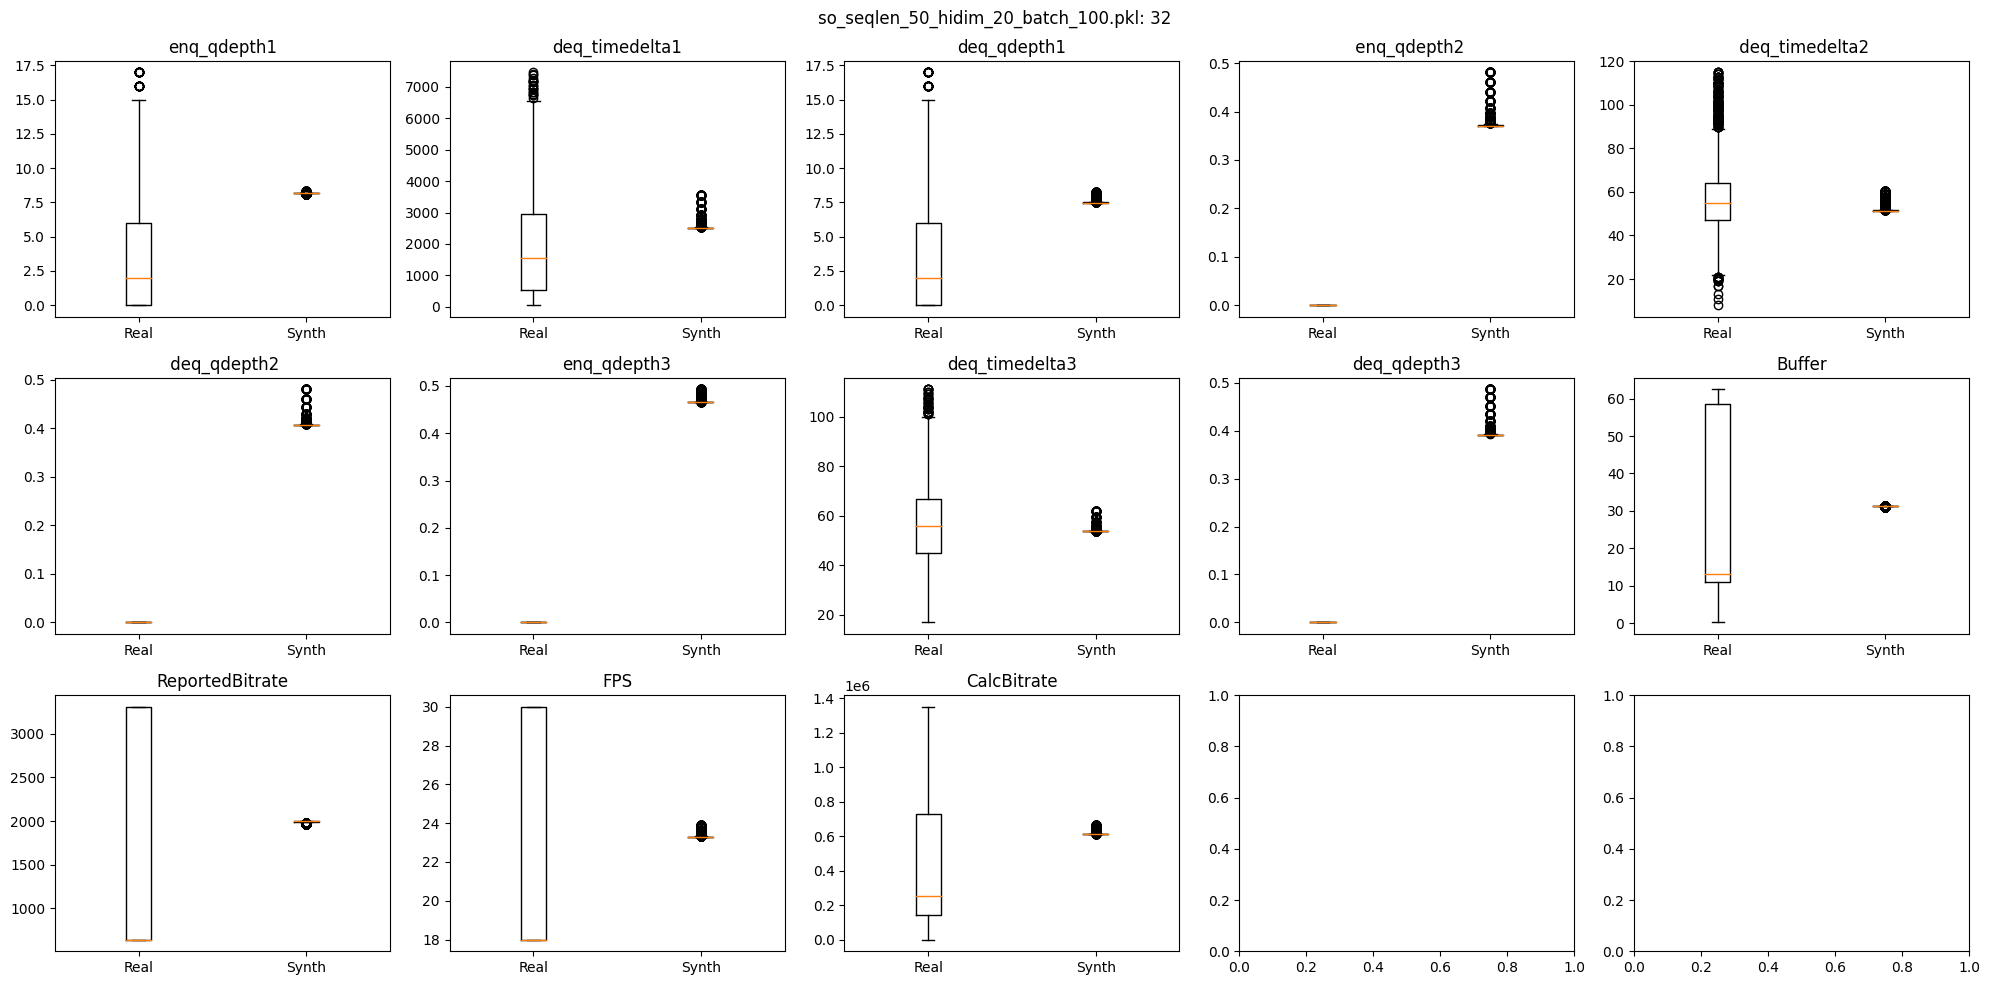

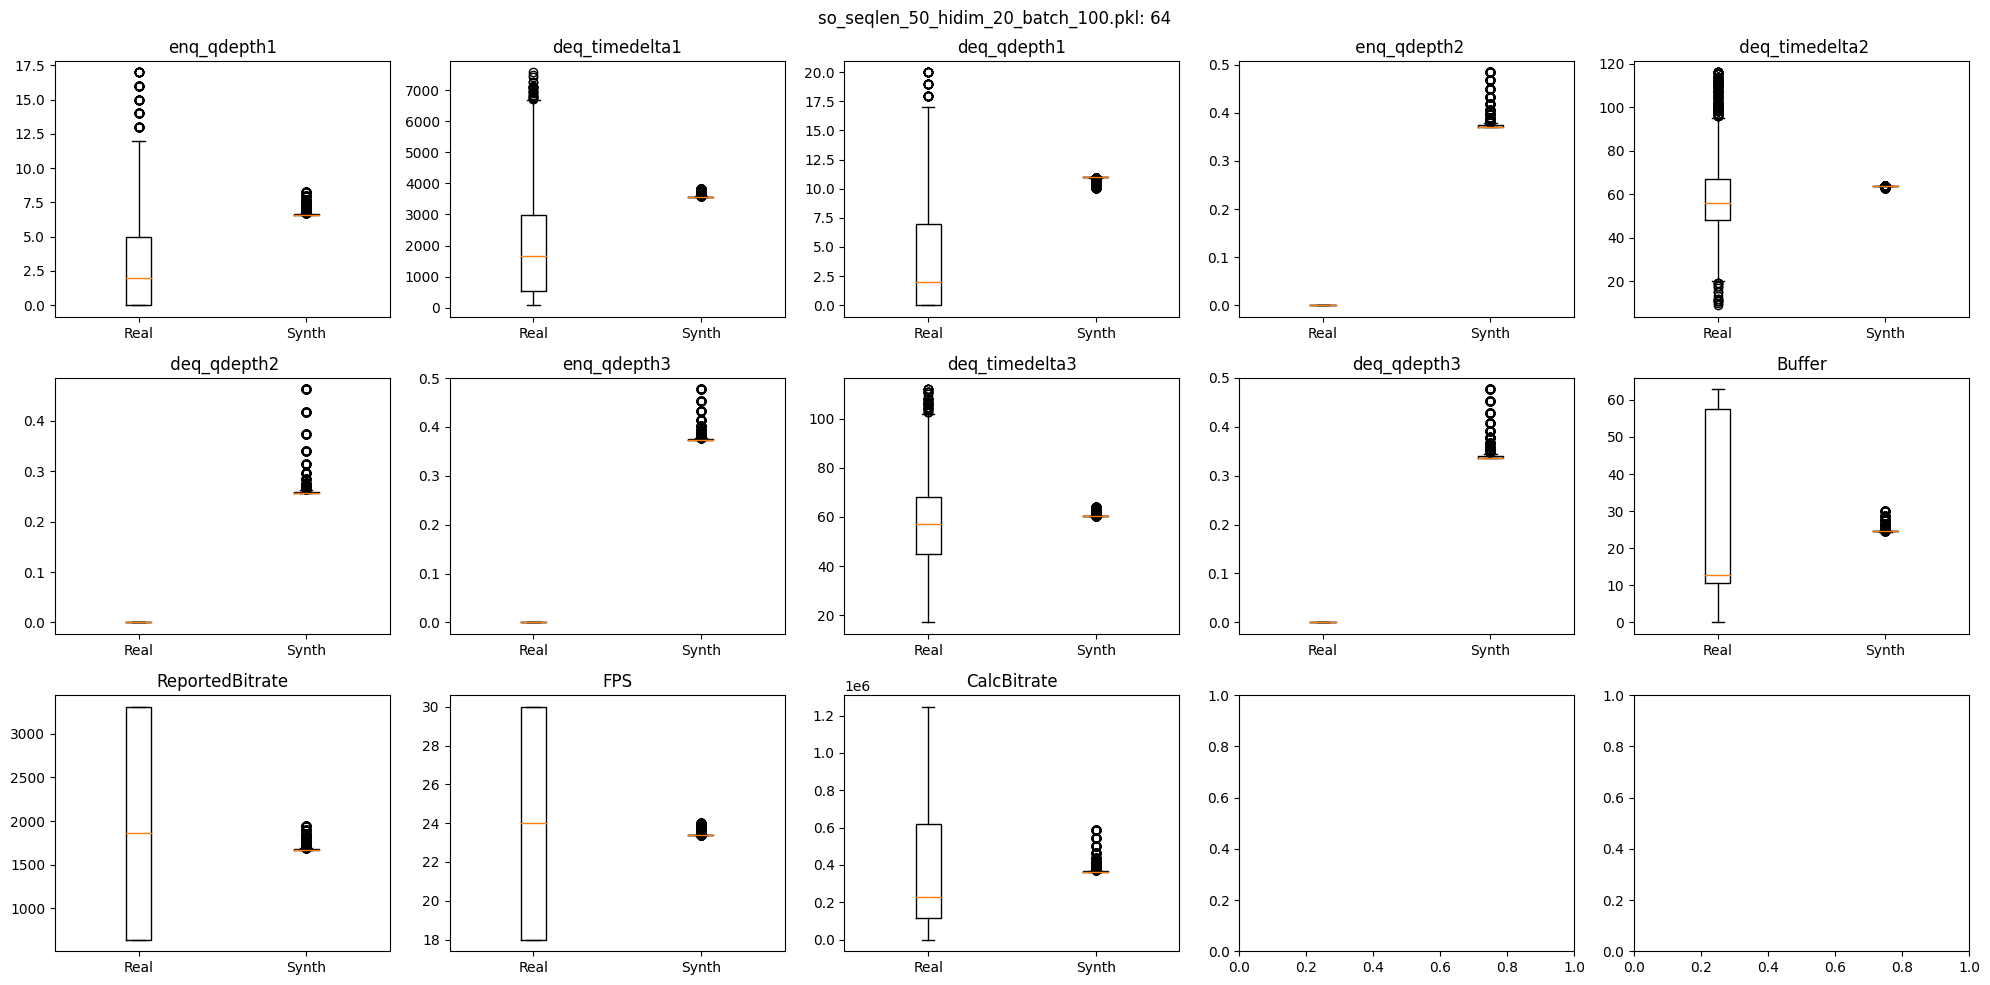

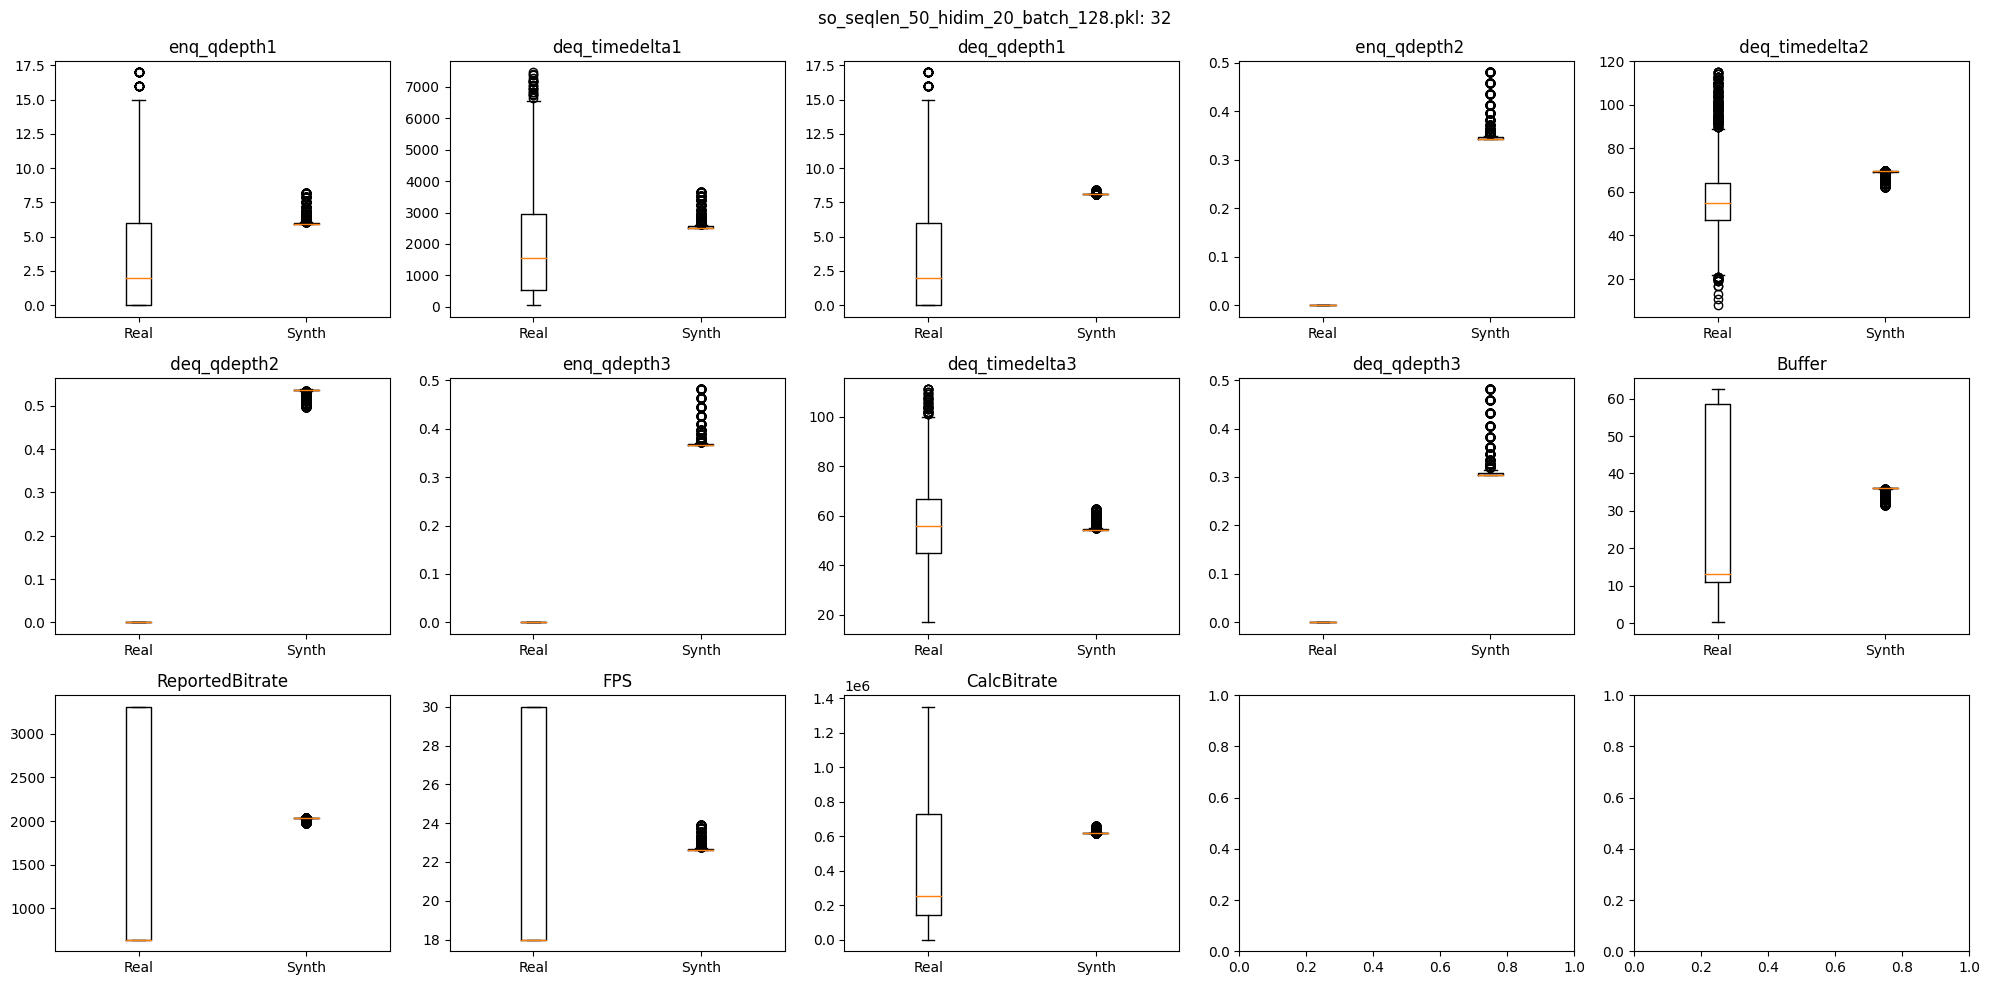

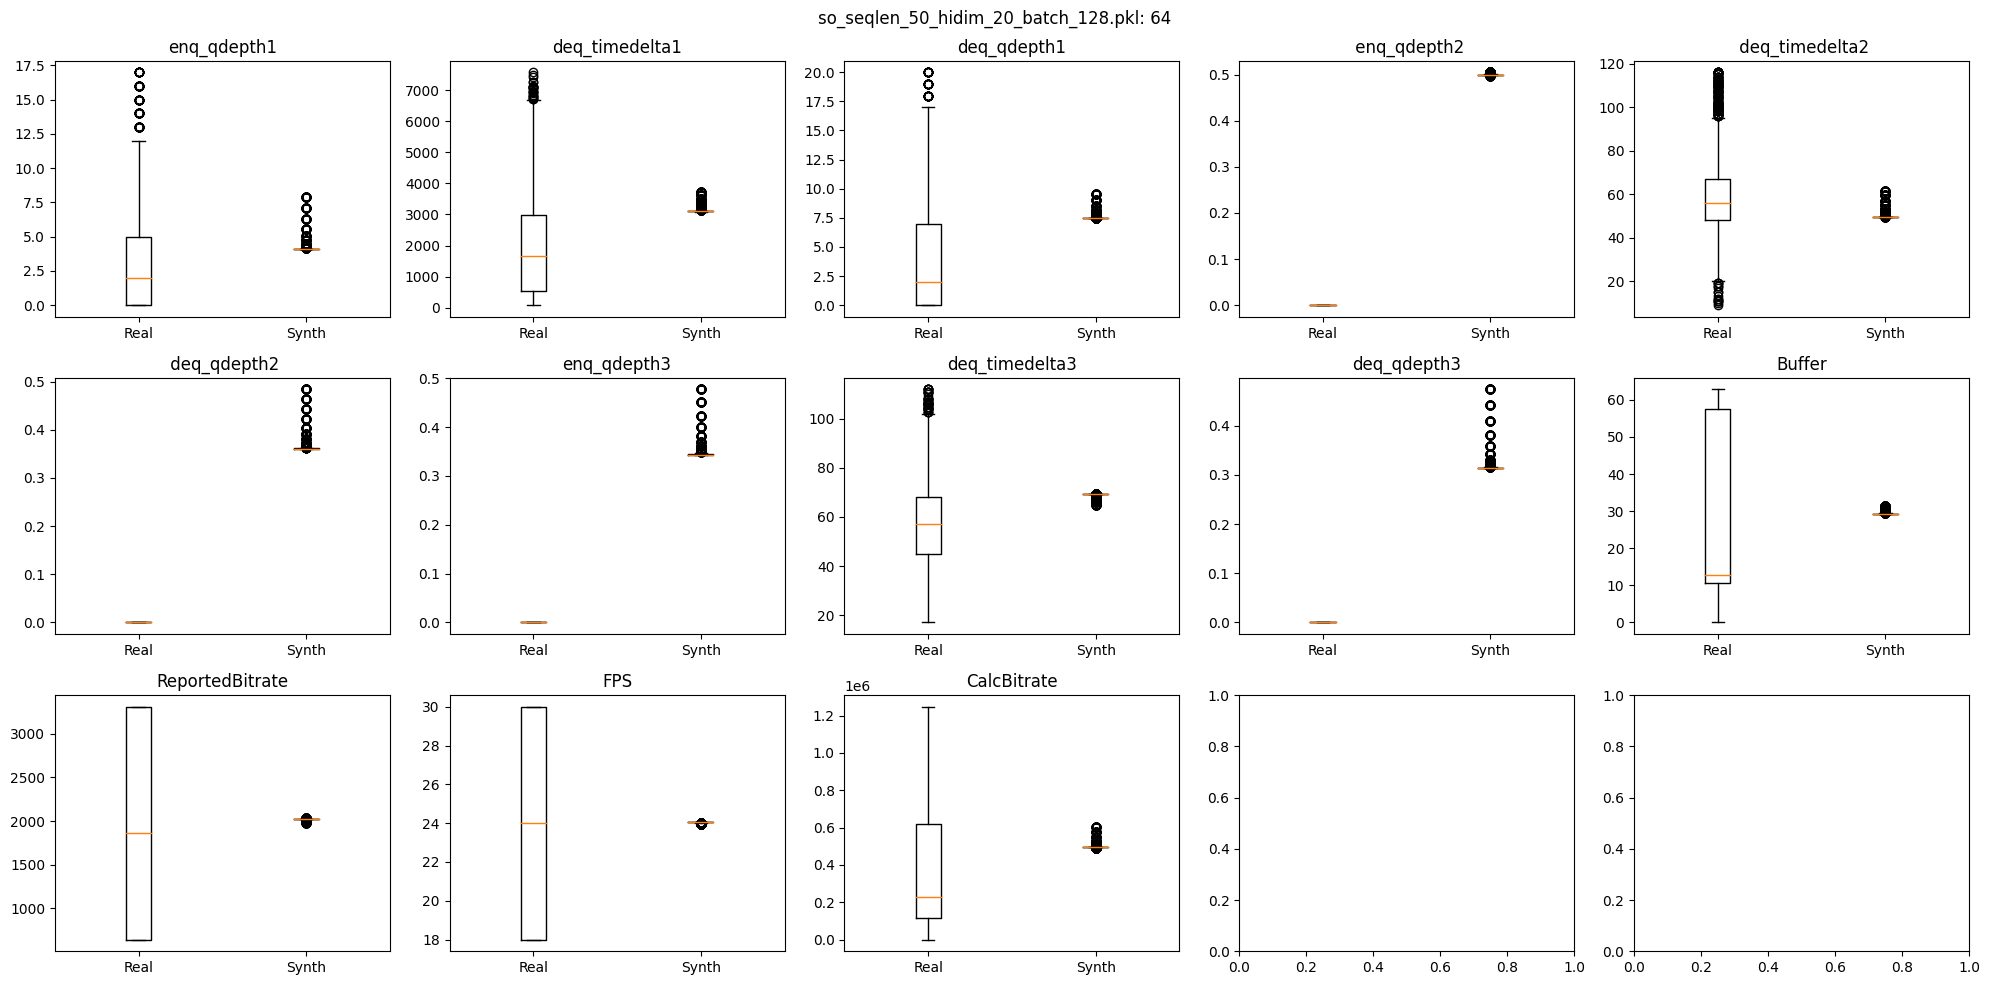

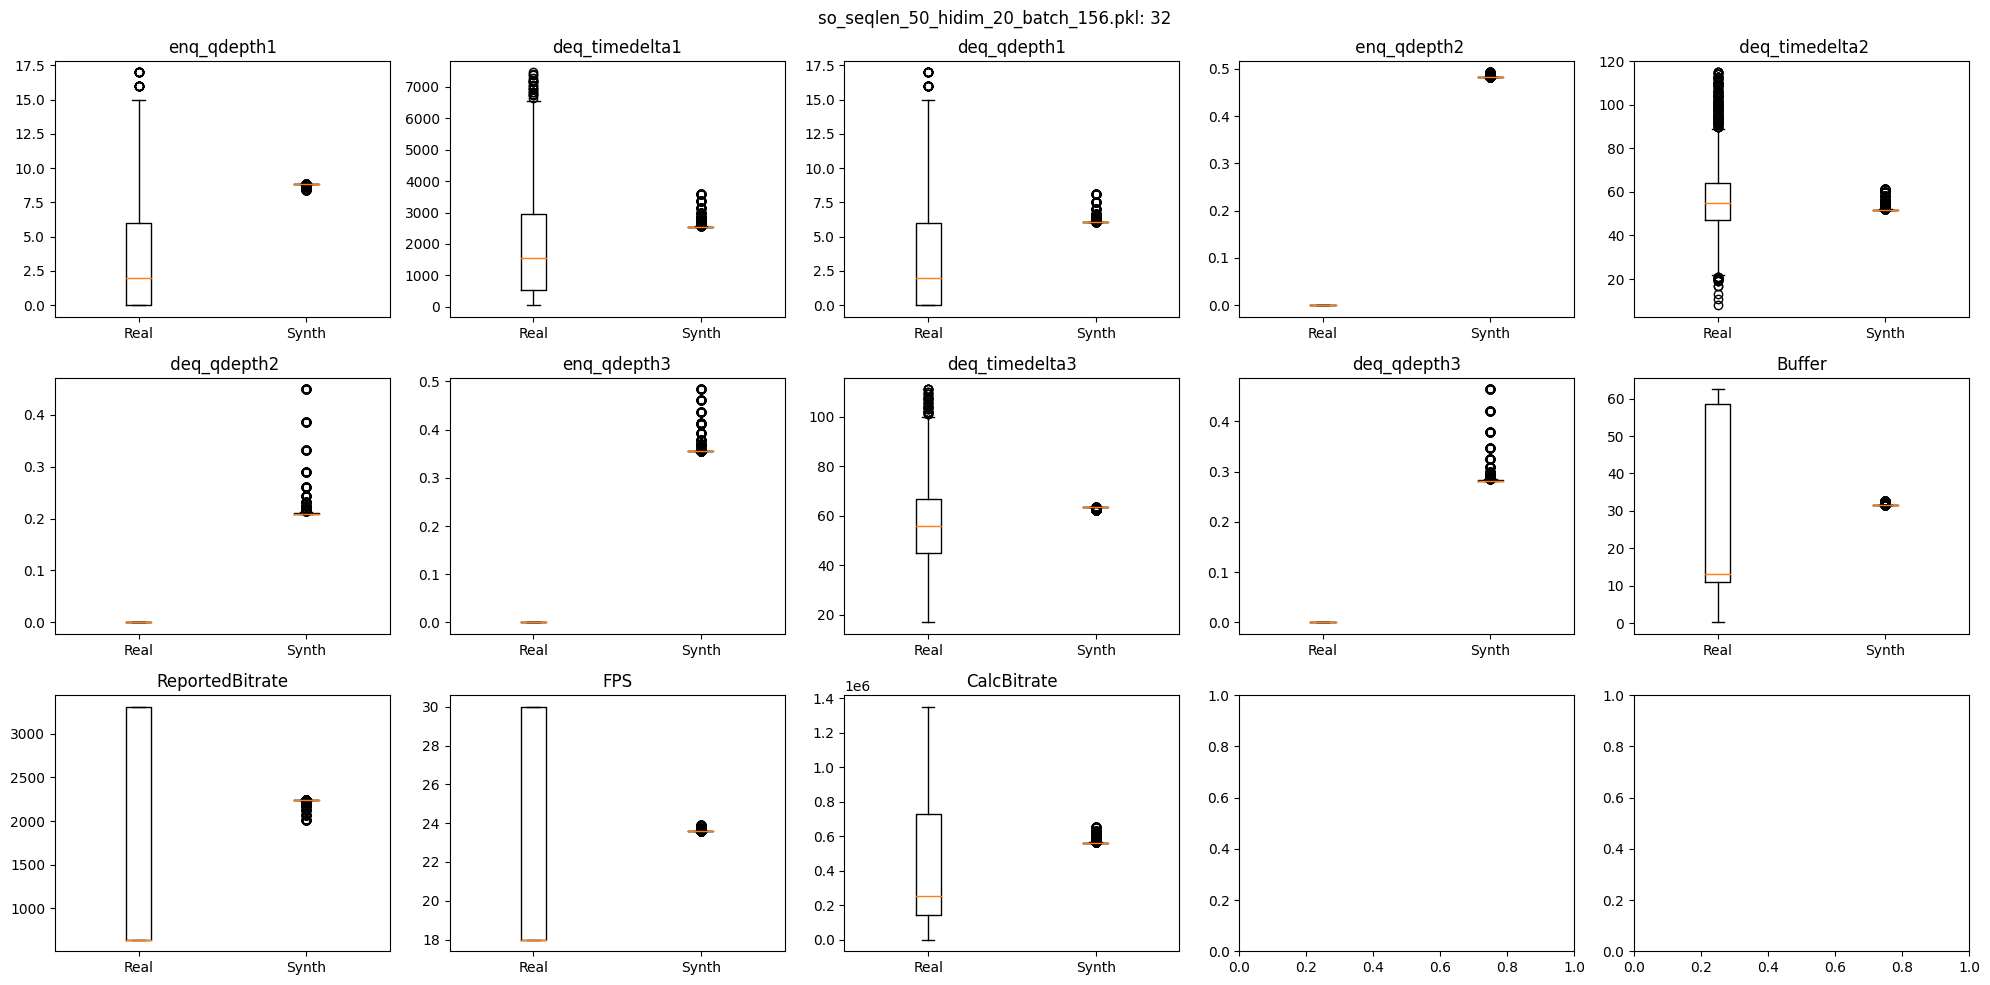

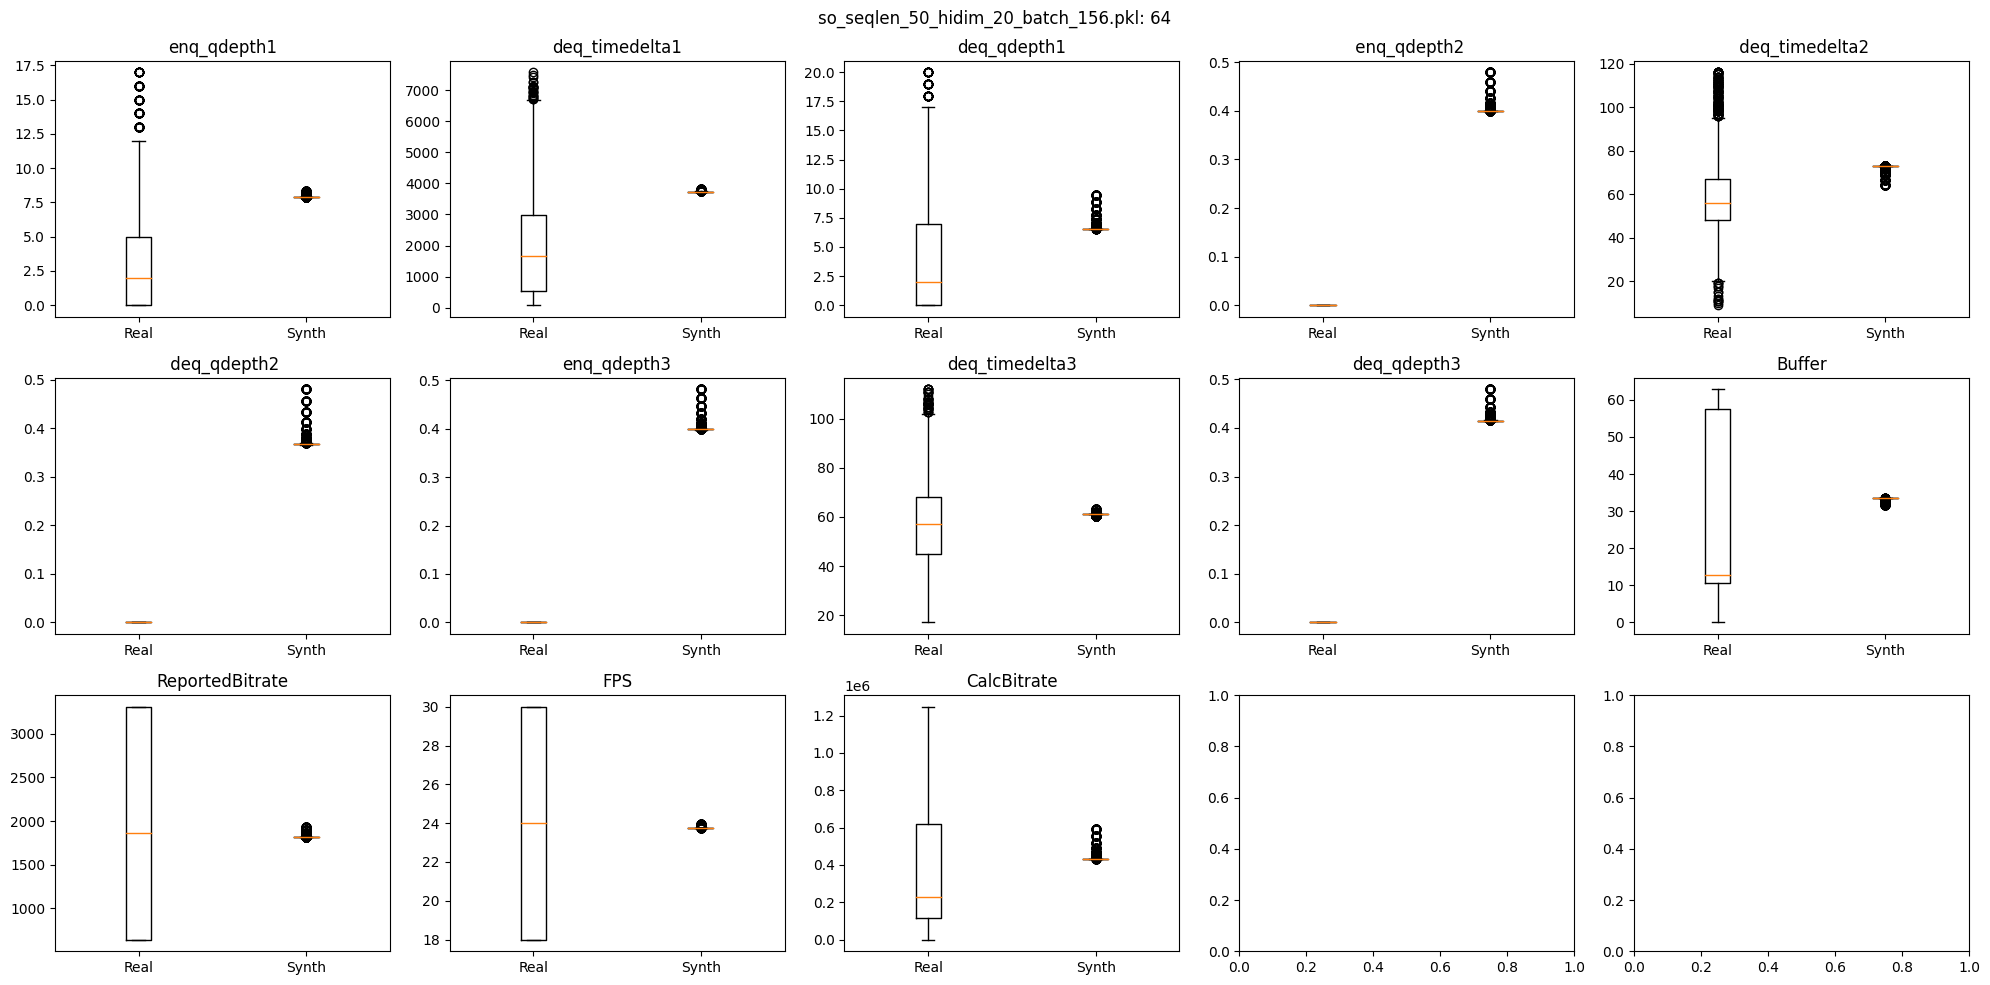

In [20]:
#Uncomment this code if you want to see the feature distributions of all models
iMax, jMax, kMax = fatNum(params.amount_of_models) 
for i in range(0,1):
    for j in range(0,1):
        for k in range(0,3):
           model = 'so_seqlen_'+str((50*(i) + 50))+'_hidim_'+str(20*(j)+20)+'_batch_'+str(28*(k)+100)+'.pkl'
           synth32 = models.get(model)[0]
           synth64 = models.get(model)[1]
           genBoxPlotAllFeatures(models_obj, model + ': 32', real_32, synth32, sample_size, num_cols, save=False, file_name= '')
           genBoxPlotAllFeatures(models_obj, model + ': 64', real_64, synth64, sample_size, num_cols, save=False, file_name= '') 

######### BOX PLOT  ##########

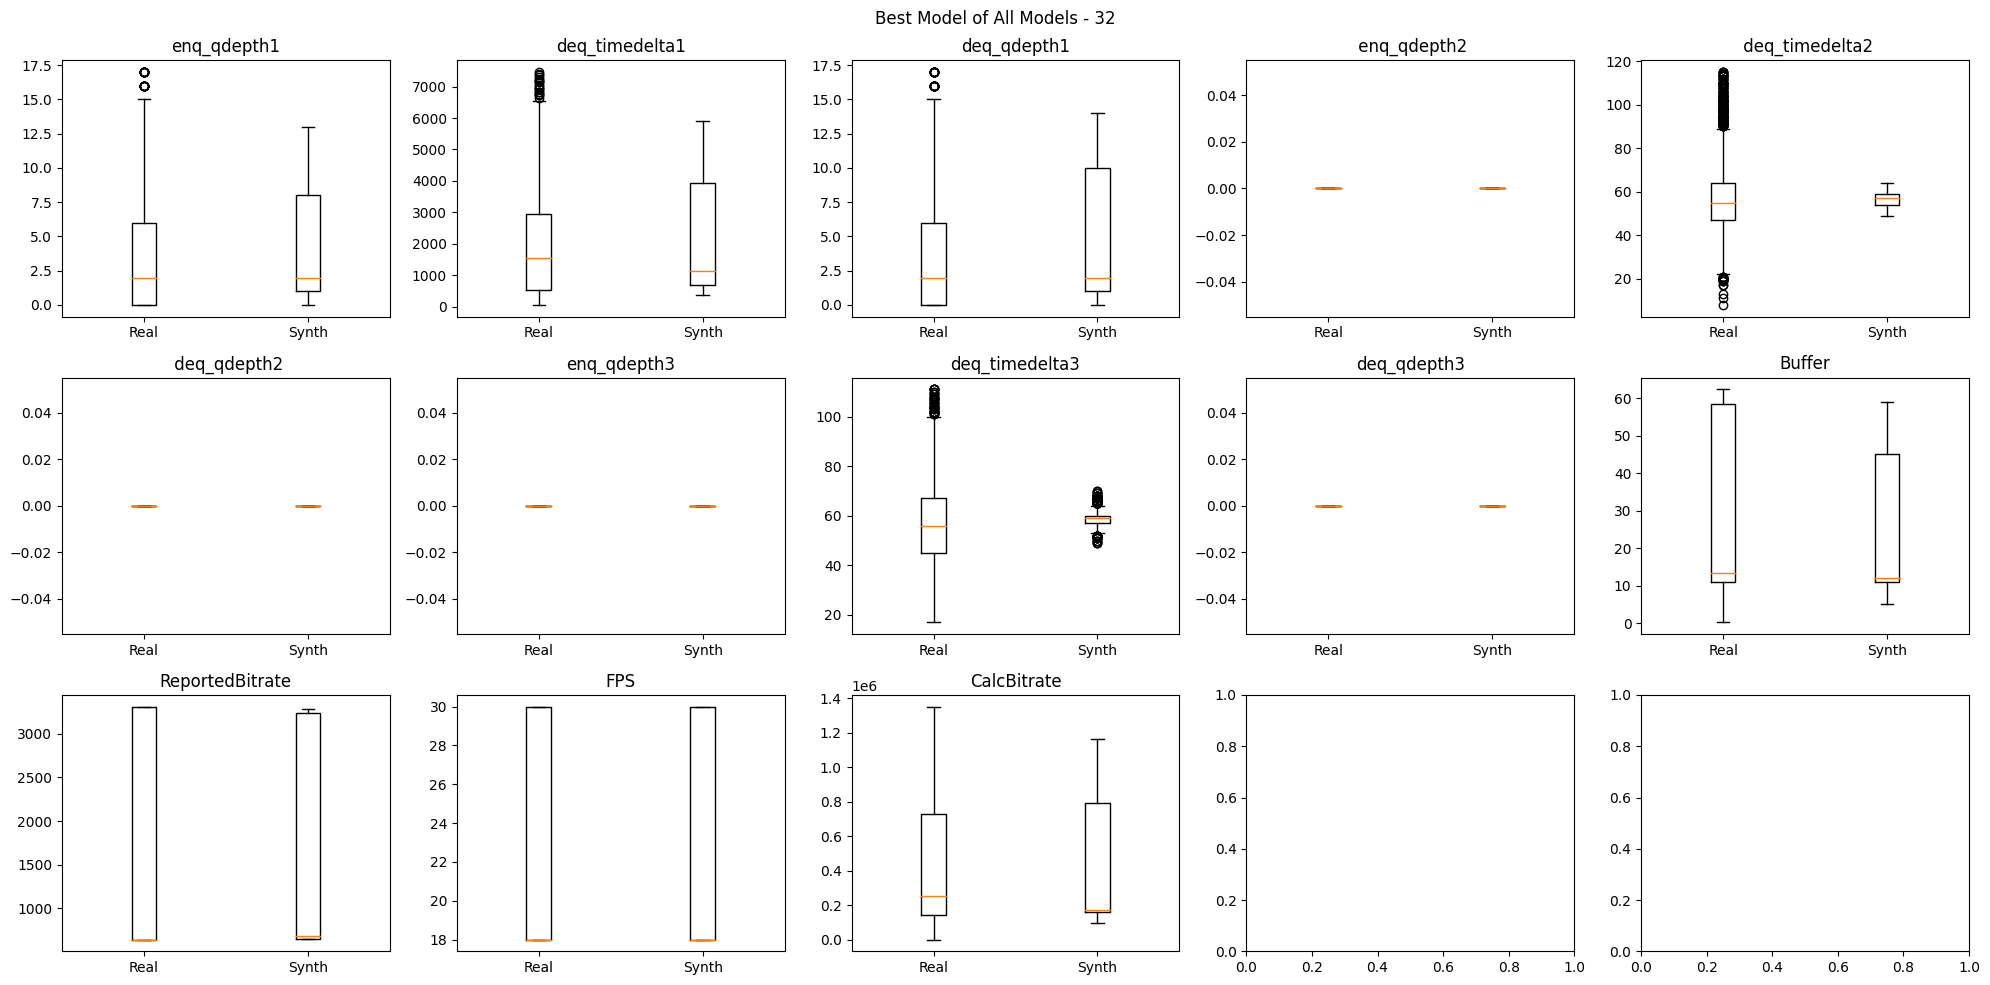

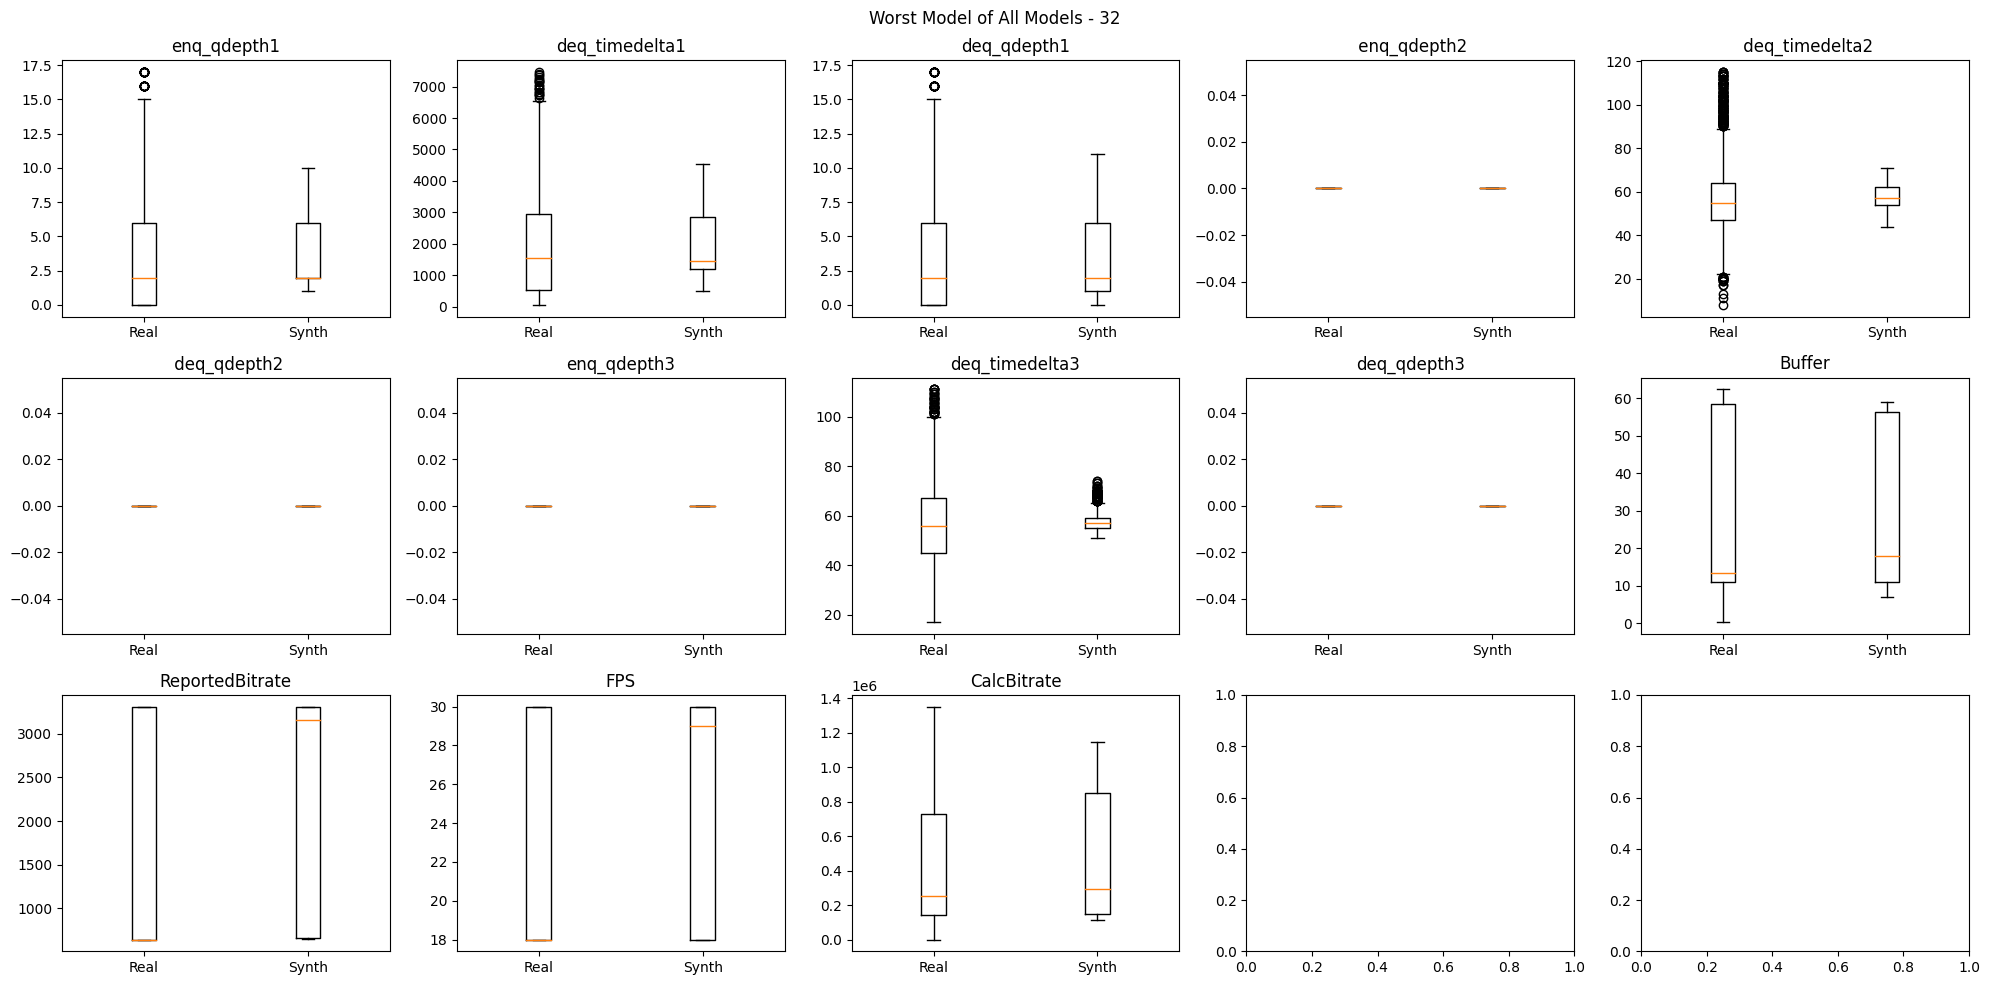

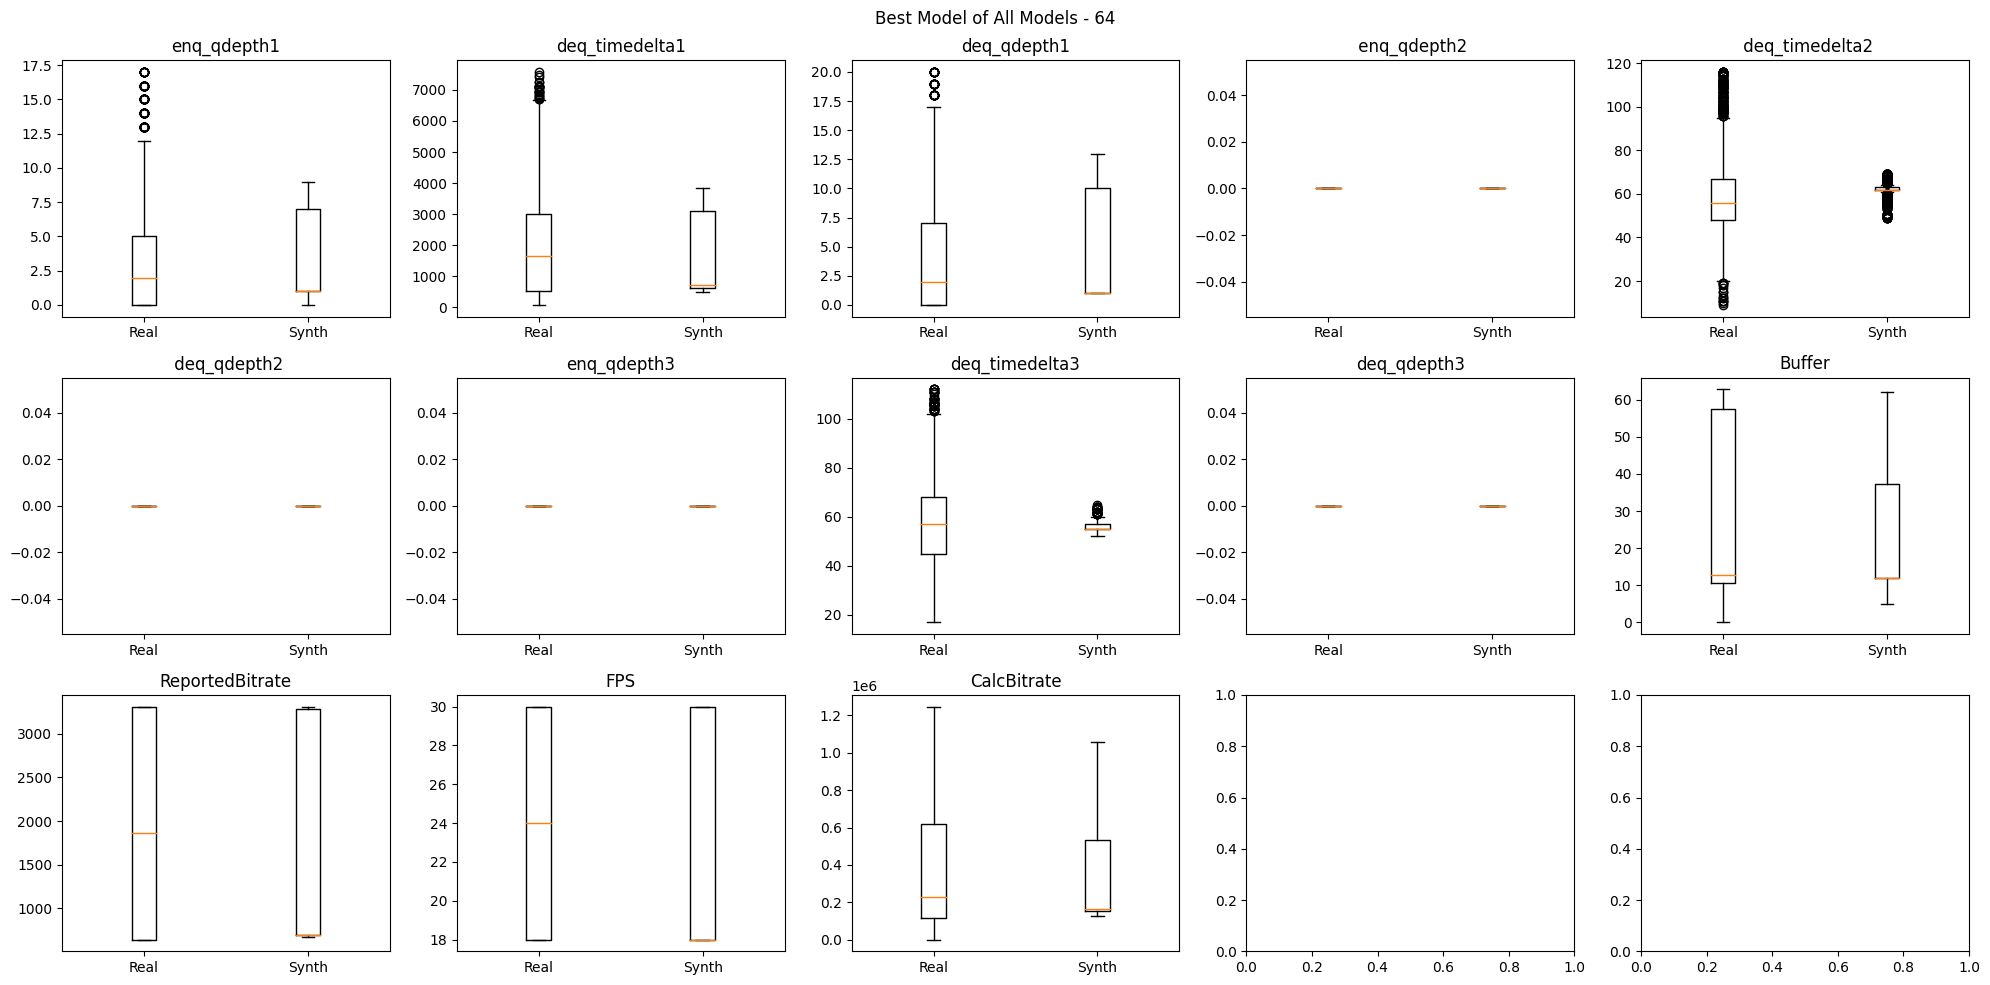

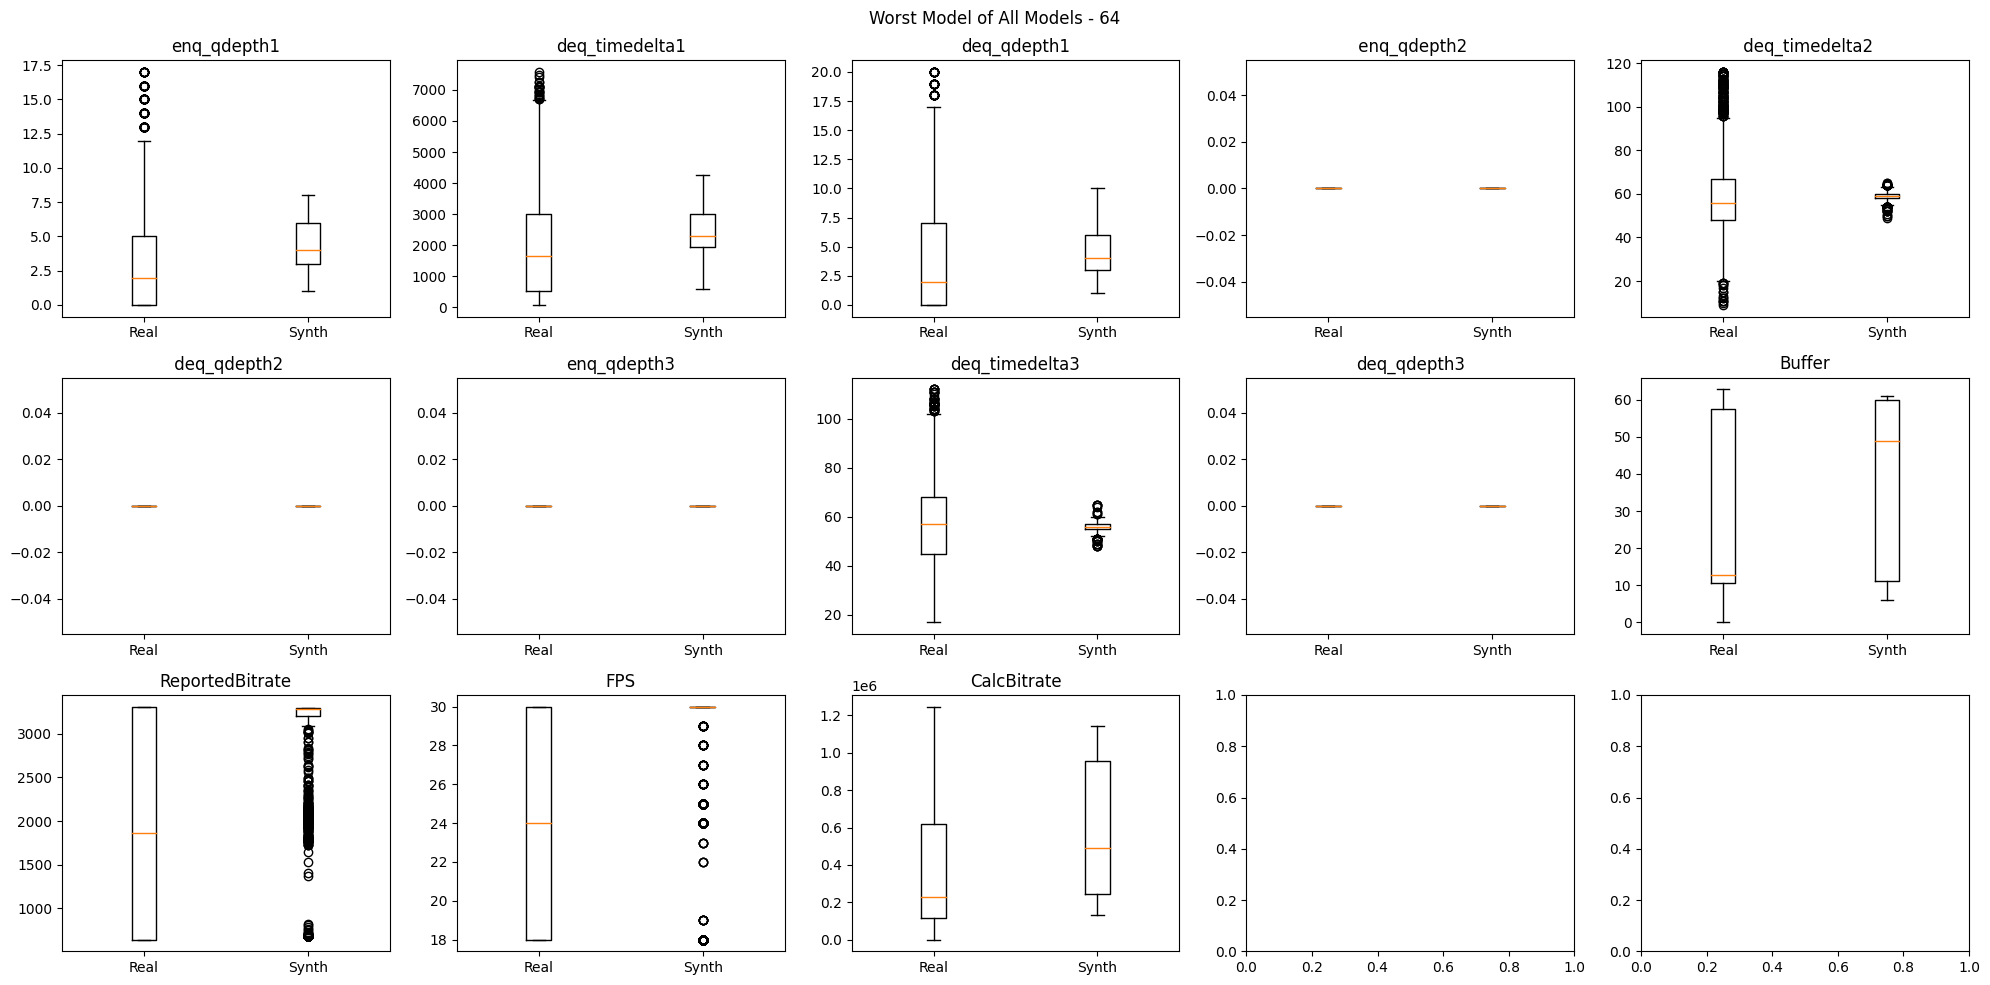

In [33]:
genBoxPlotAllFeatures(models_obj, 'Best Model of All Models - 32', real_32, best_modelsum_32, sample_size, num_cols, save=True, file_name='32_best_model_sum')
genBoxPlotAllFeatures(models_obj, 'Worst Model of All Models - 32', real_32, worst_modelsum_32, sample_size, num_cols, save=True, file_name='32_worst_model_sum')
genBoxPlotAllFeatures(models_obj, 'Best Model of All Models - 64', real_64, best_modelsum_64, sample_size, num_cols, save=True, file_name='64_best_model_sum')
genBoxPlotAllFeatures(models_obj, 'Worst Model of All Models - 64', real_64, worst_modelsum_64, sample_size, num_cols, save=True, file_name='64_worst_model_sum')


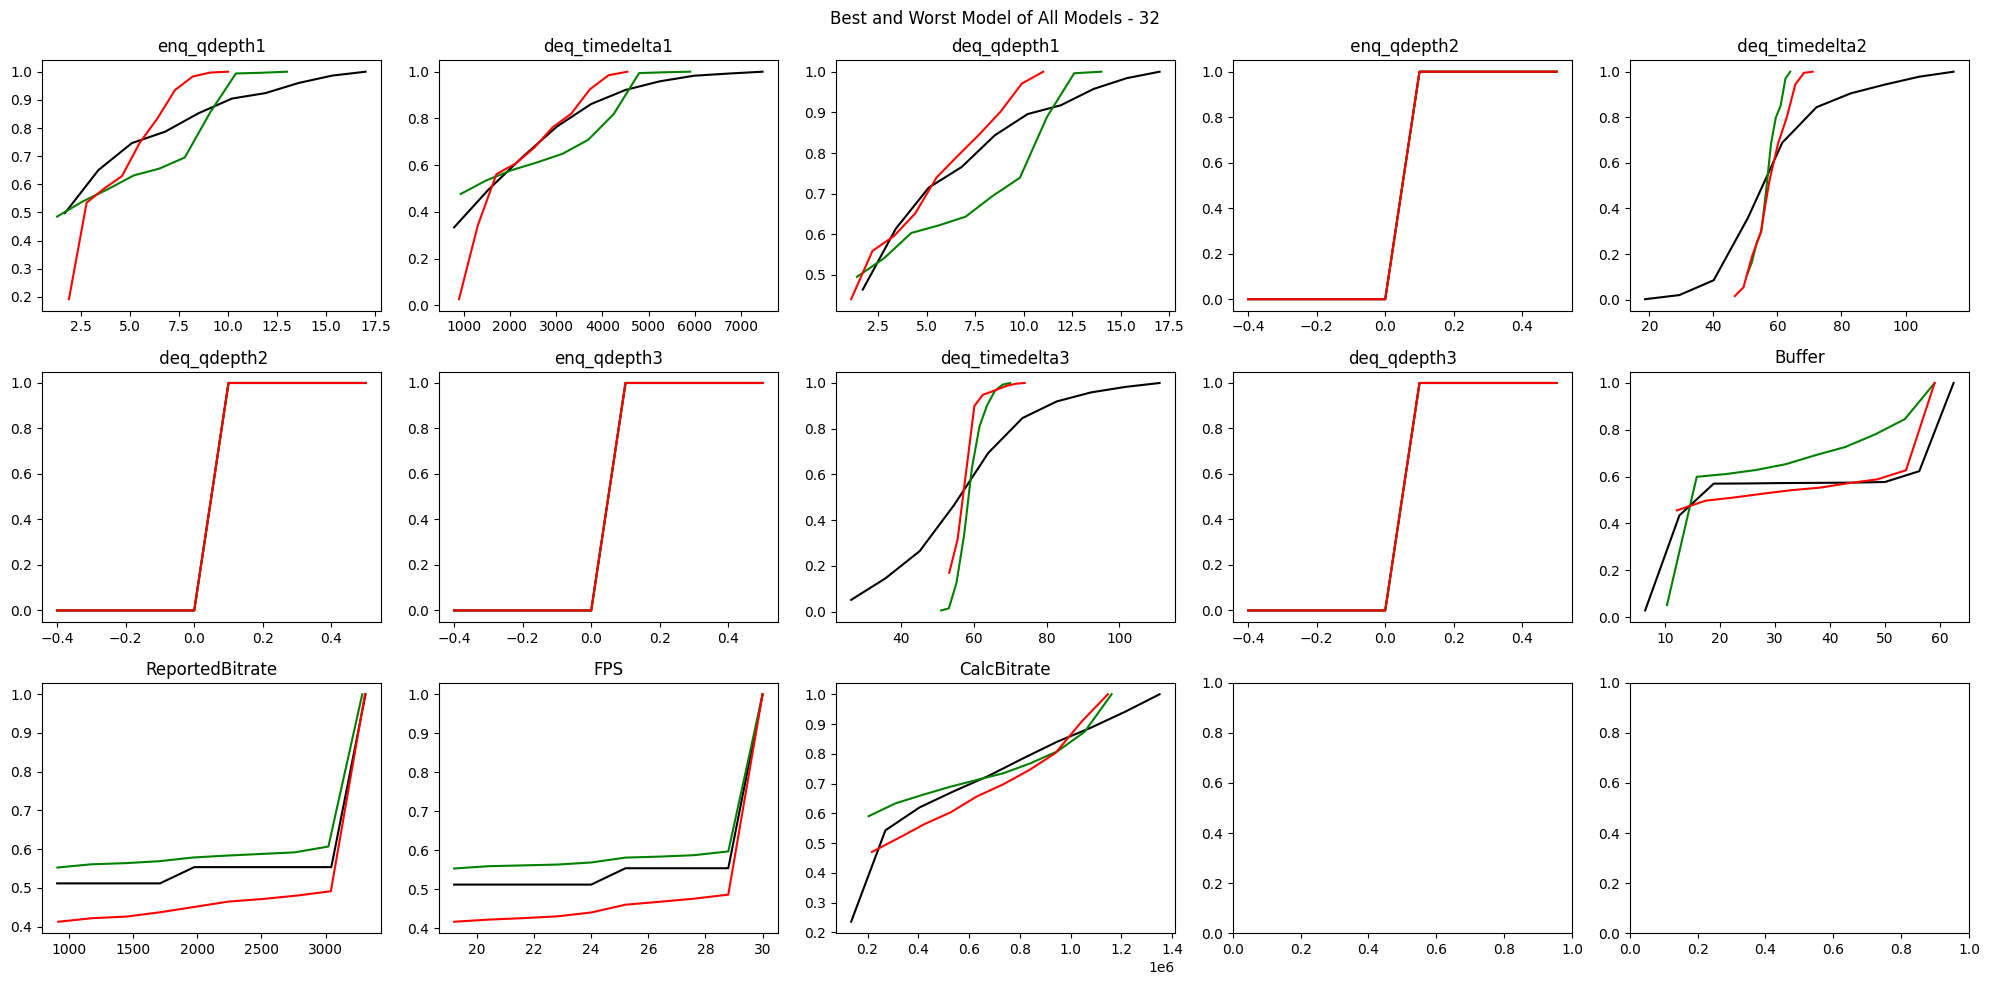

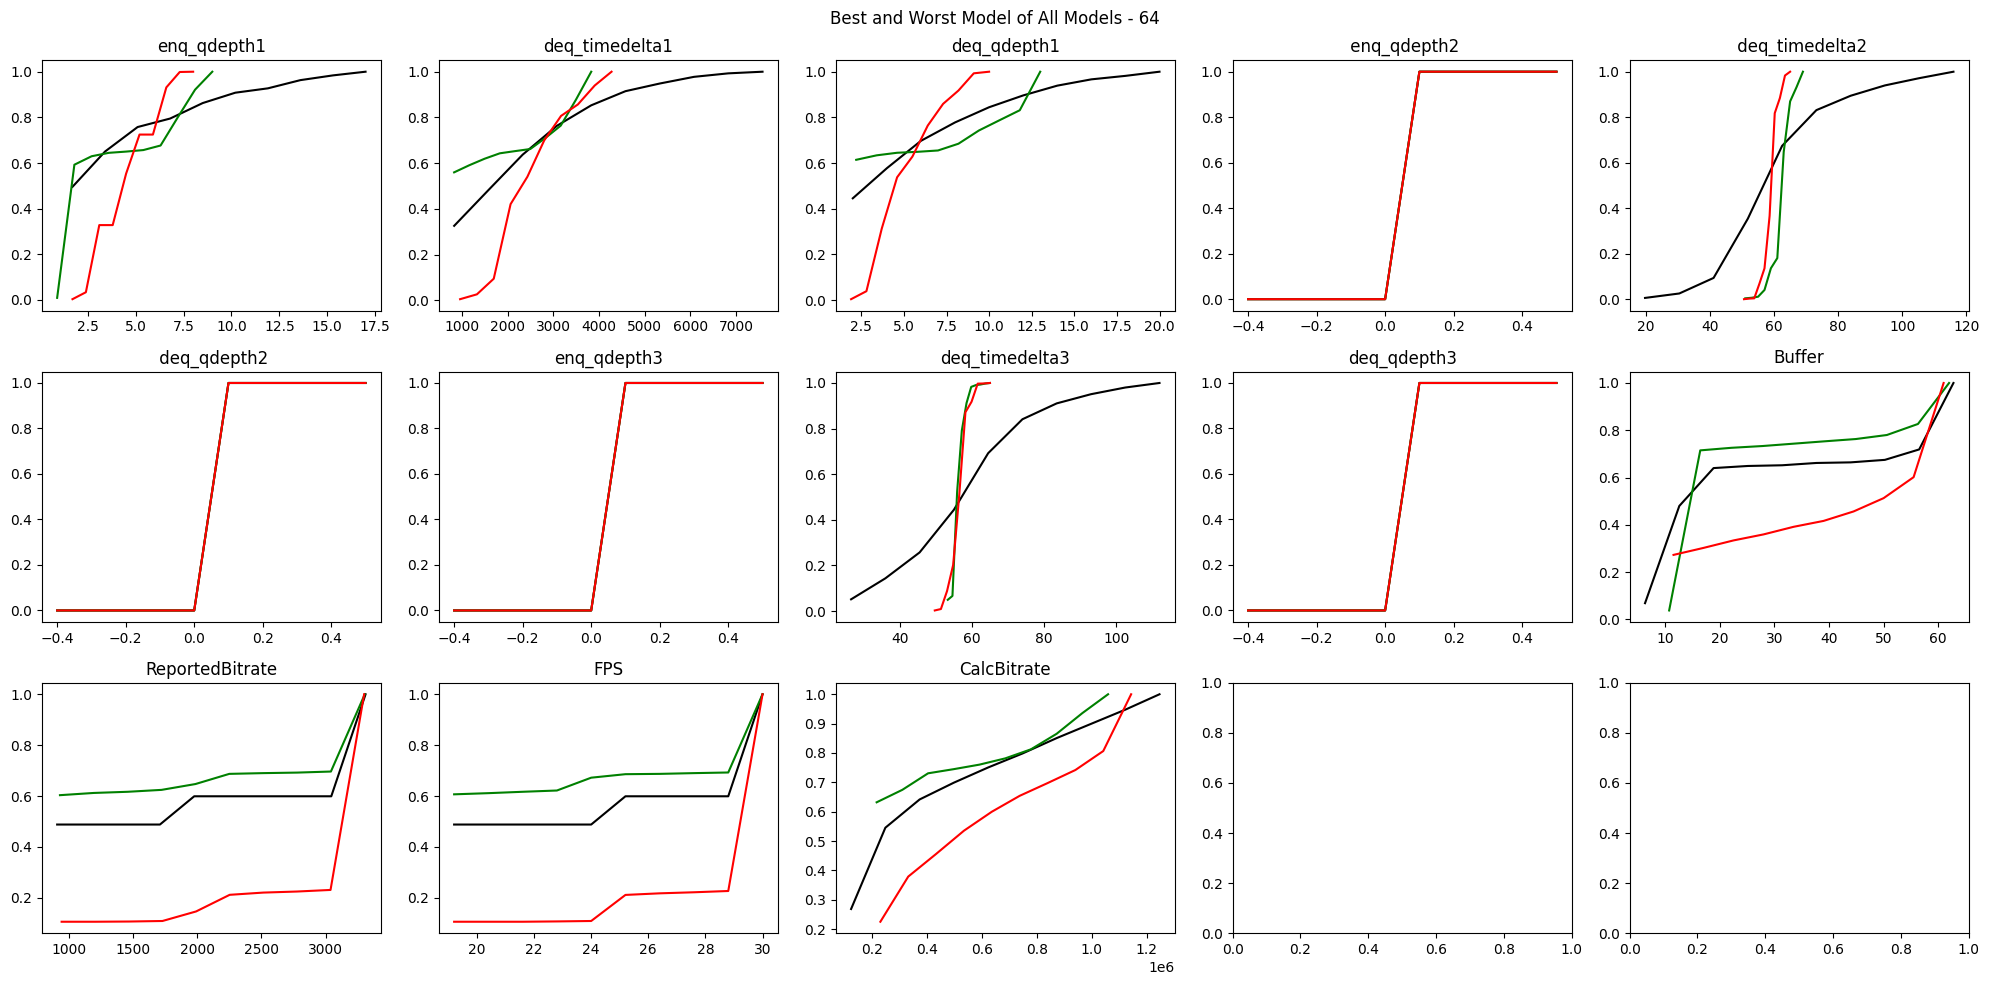

In [34]:
genBestWorstCDFAllFeatures(models_obj, 'Best and Worst Model of All Models - 32', real_32, best_modelsum_32, worst_modelsum_32, sample_size, num_cols, save=True, file_name='32_best_worst_modelsum')
genBestWorstCDFAllFeatures(models_obj, 'Best and Worst Model of All Models - 64', real_64, best_modelsum_64, worst_modelsum_64, sample_size, num_cols, save=True, file_name='64_best_worst_modelsum')

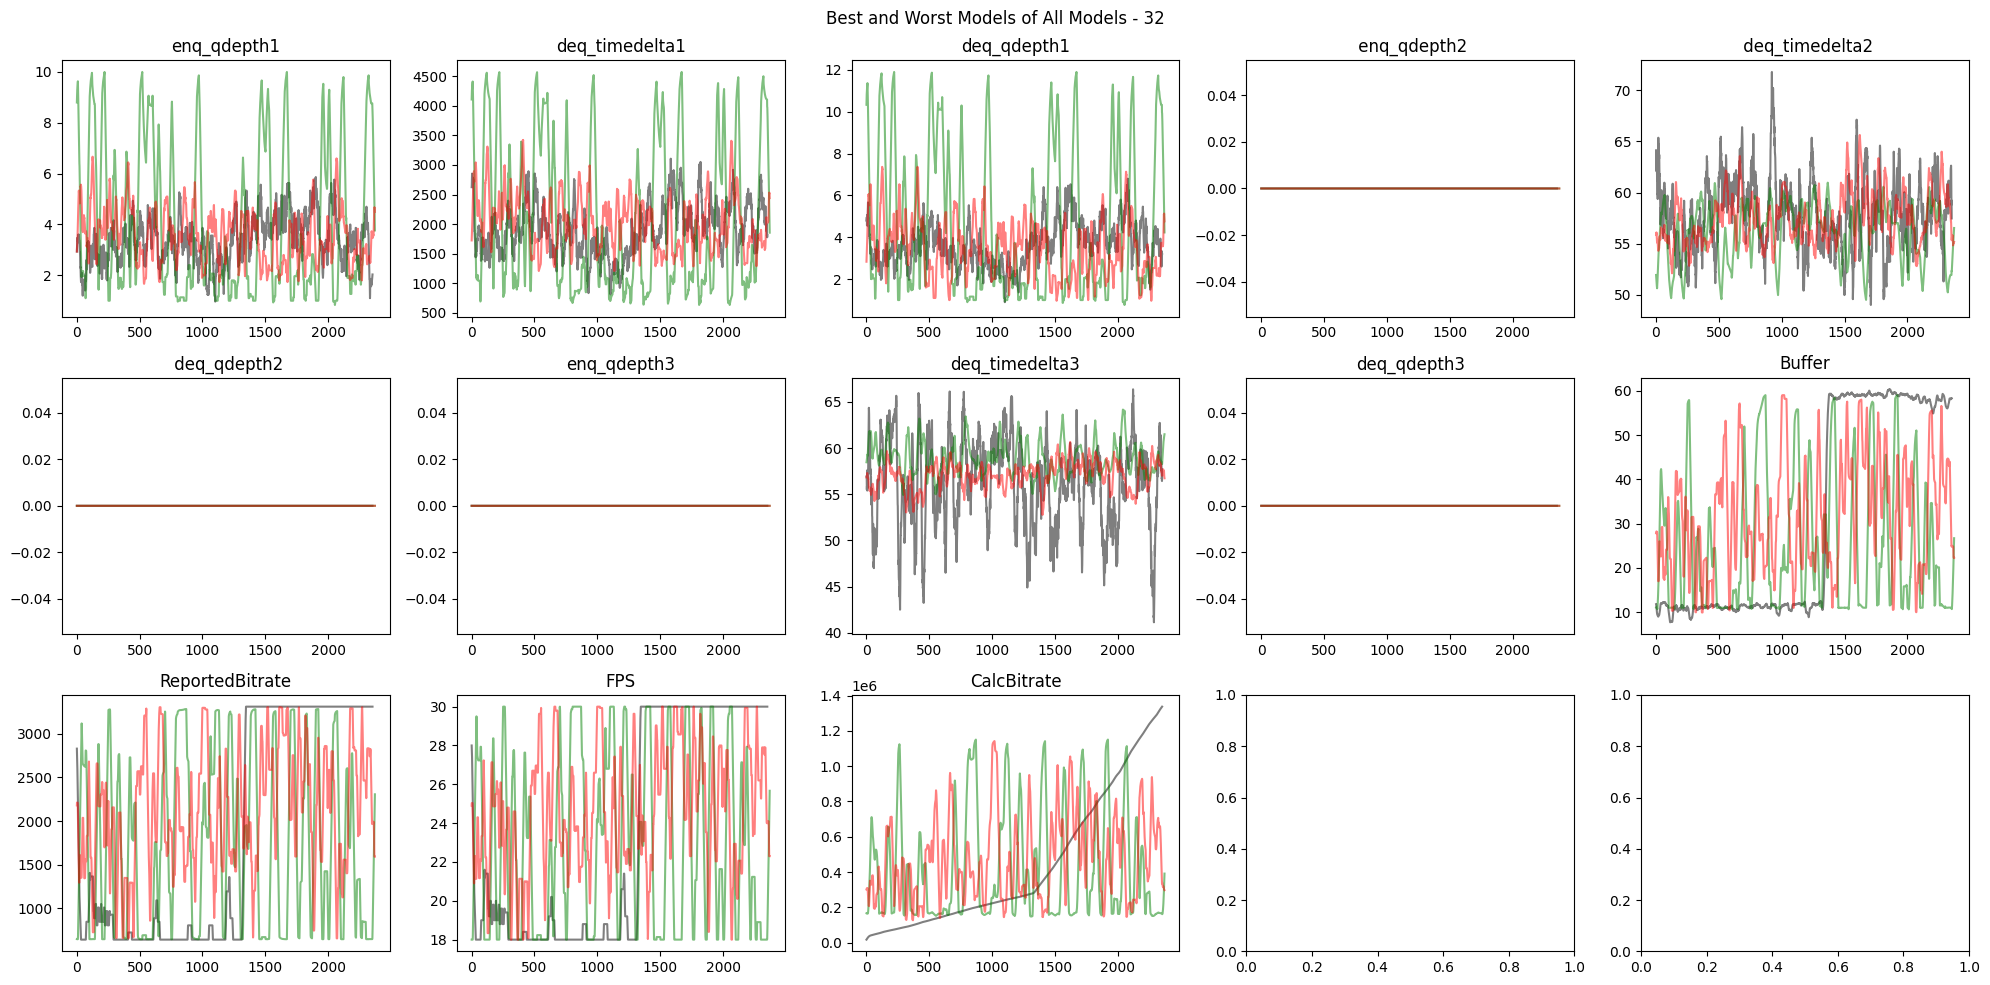

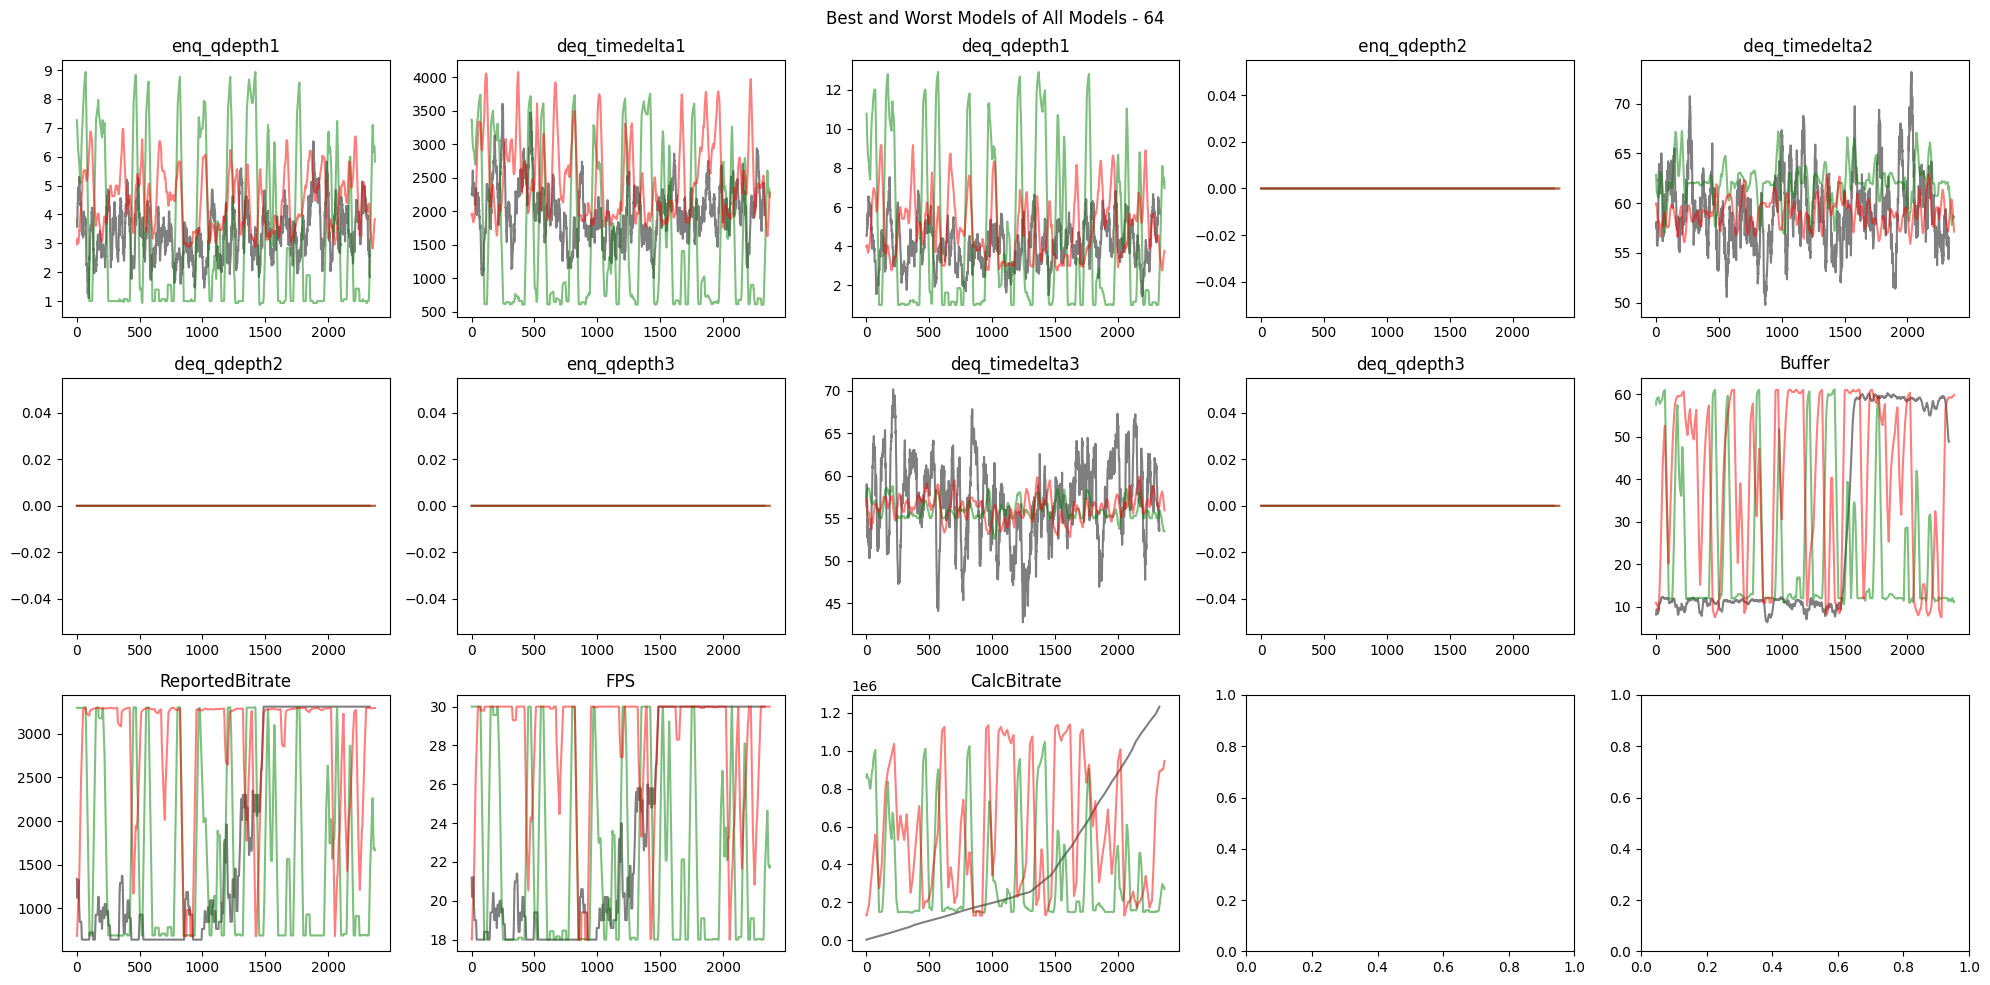

In [35]:
genEMAPlotAllFeatures(models_obj, 'Best and Worst Models of All Models - 32', real_32, best_modelsum_32, worst_modelsum_32, 30, sample_size, num_cols, save=True, file_name='32_best_models_sum')
genEMAPlotAllFeatures(models_obj, 'Best and Worst Models of All Models - 64', real_64, best_modelsum_64, worst_modelsum_64, 30, sample_size, num_cols, save=True, file_name='64_best_models_sum')

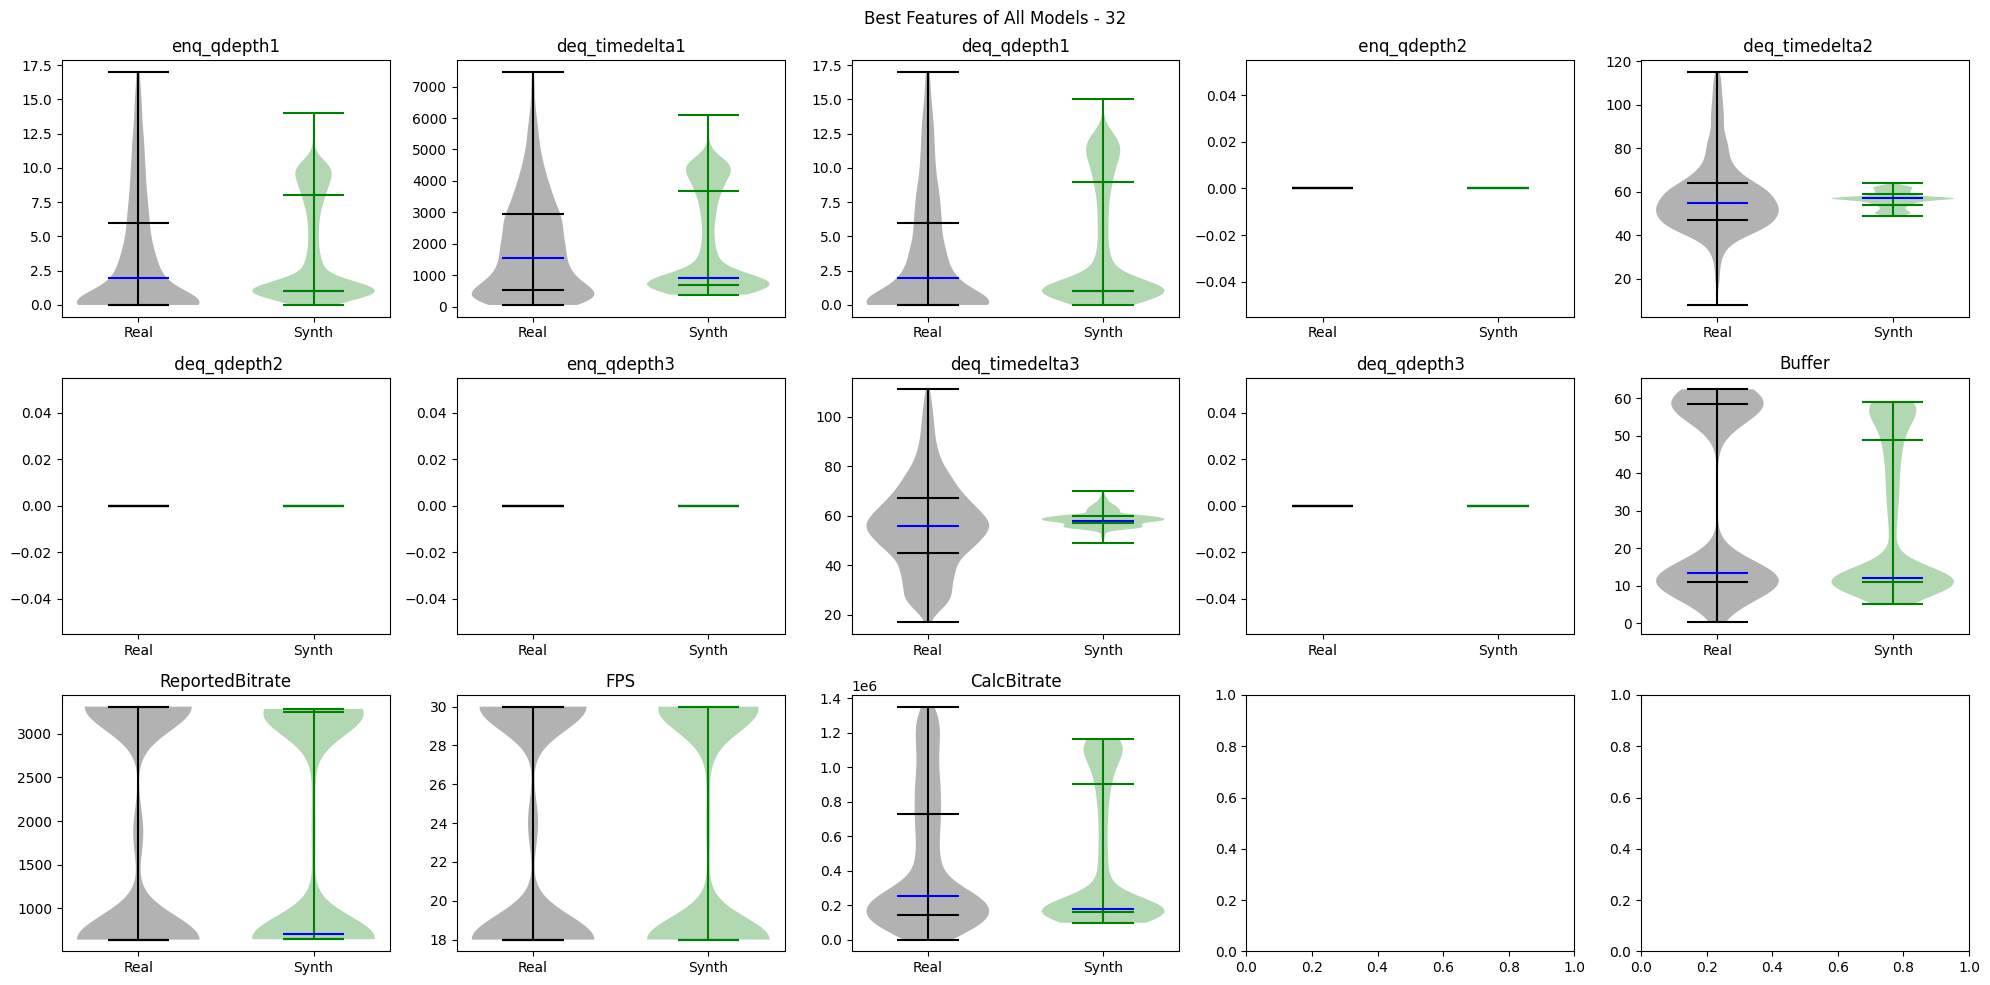

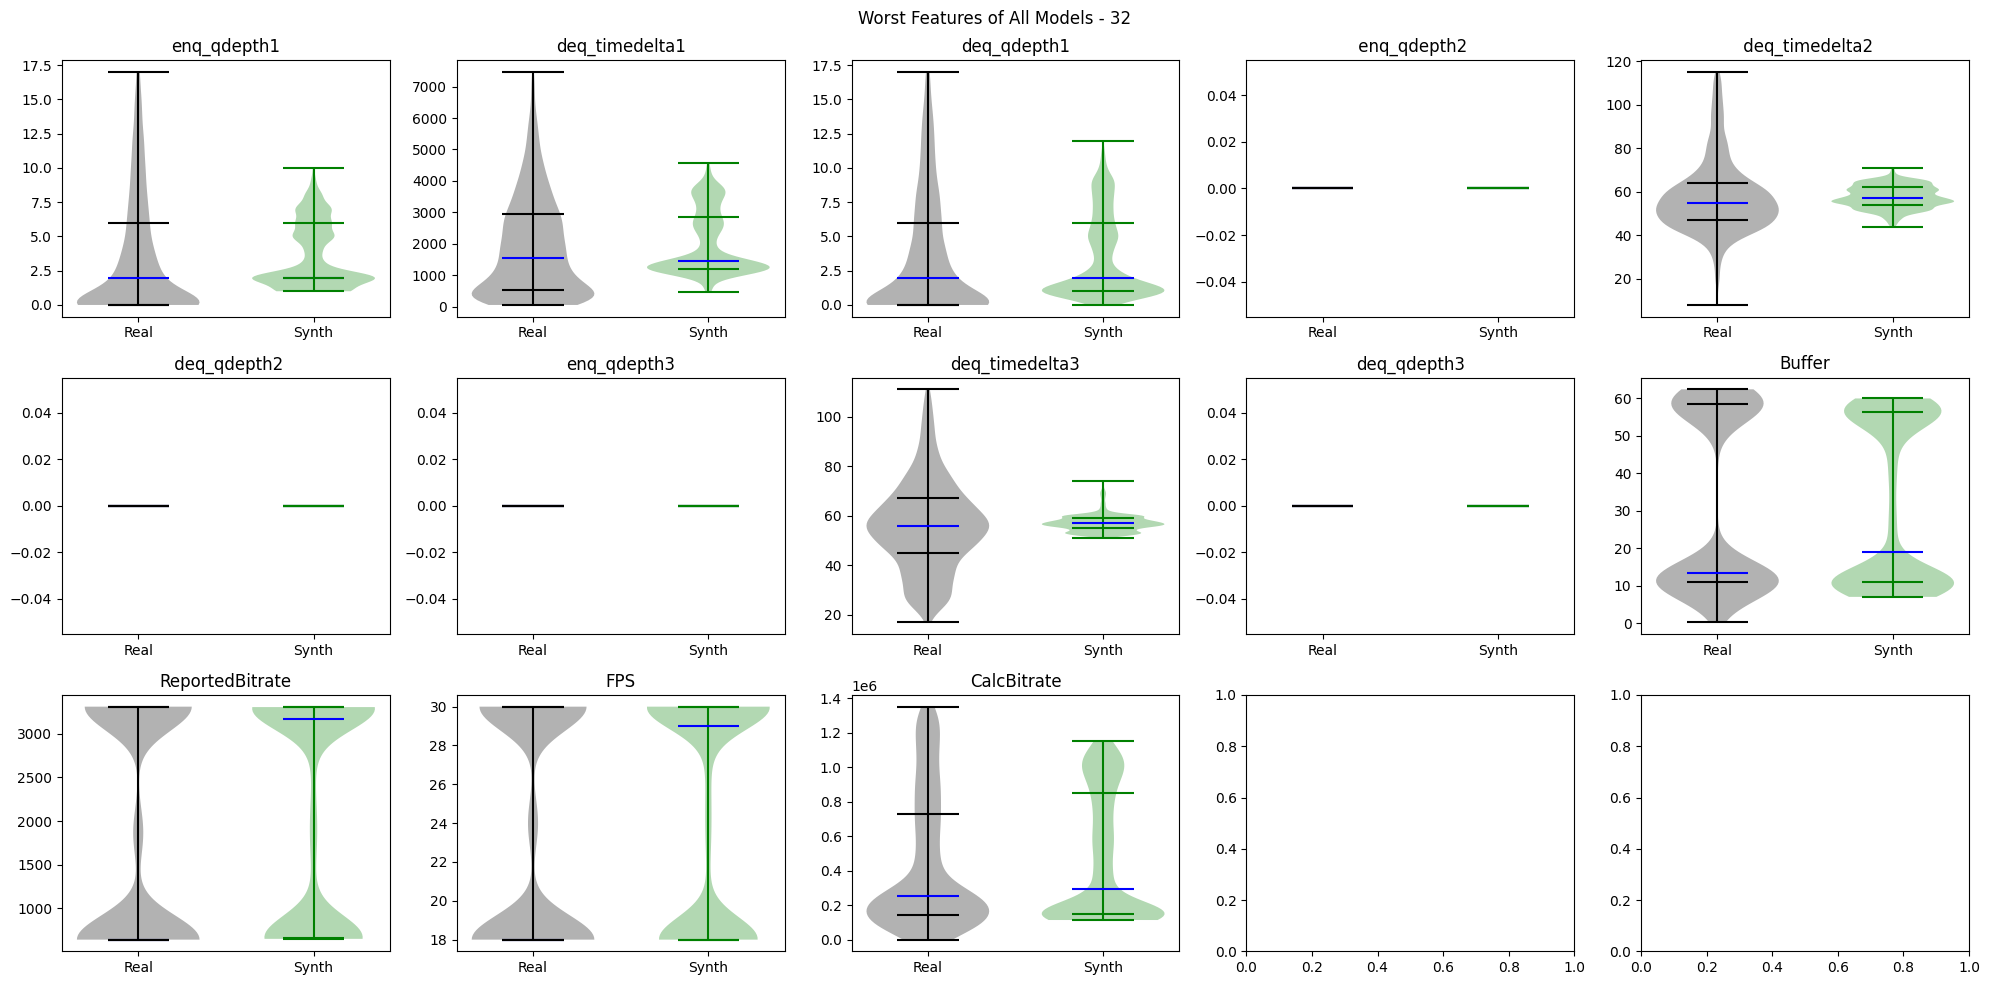

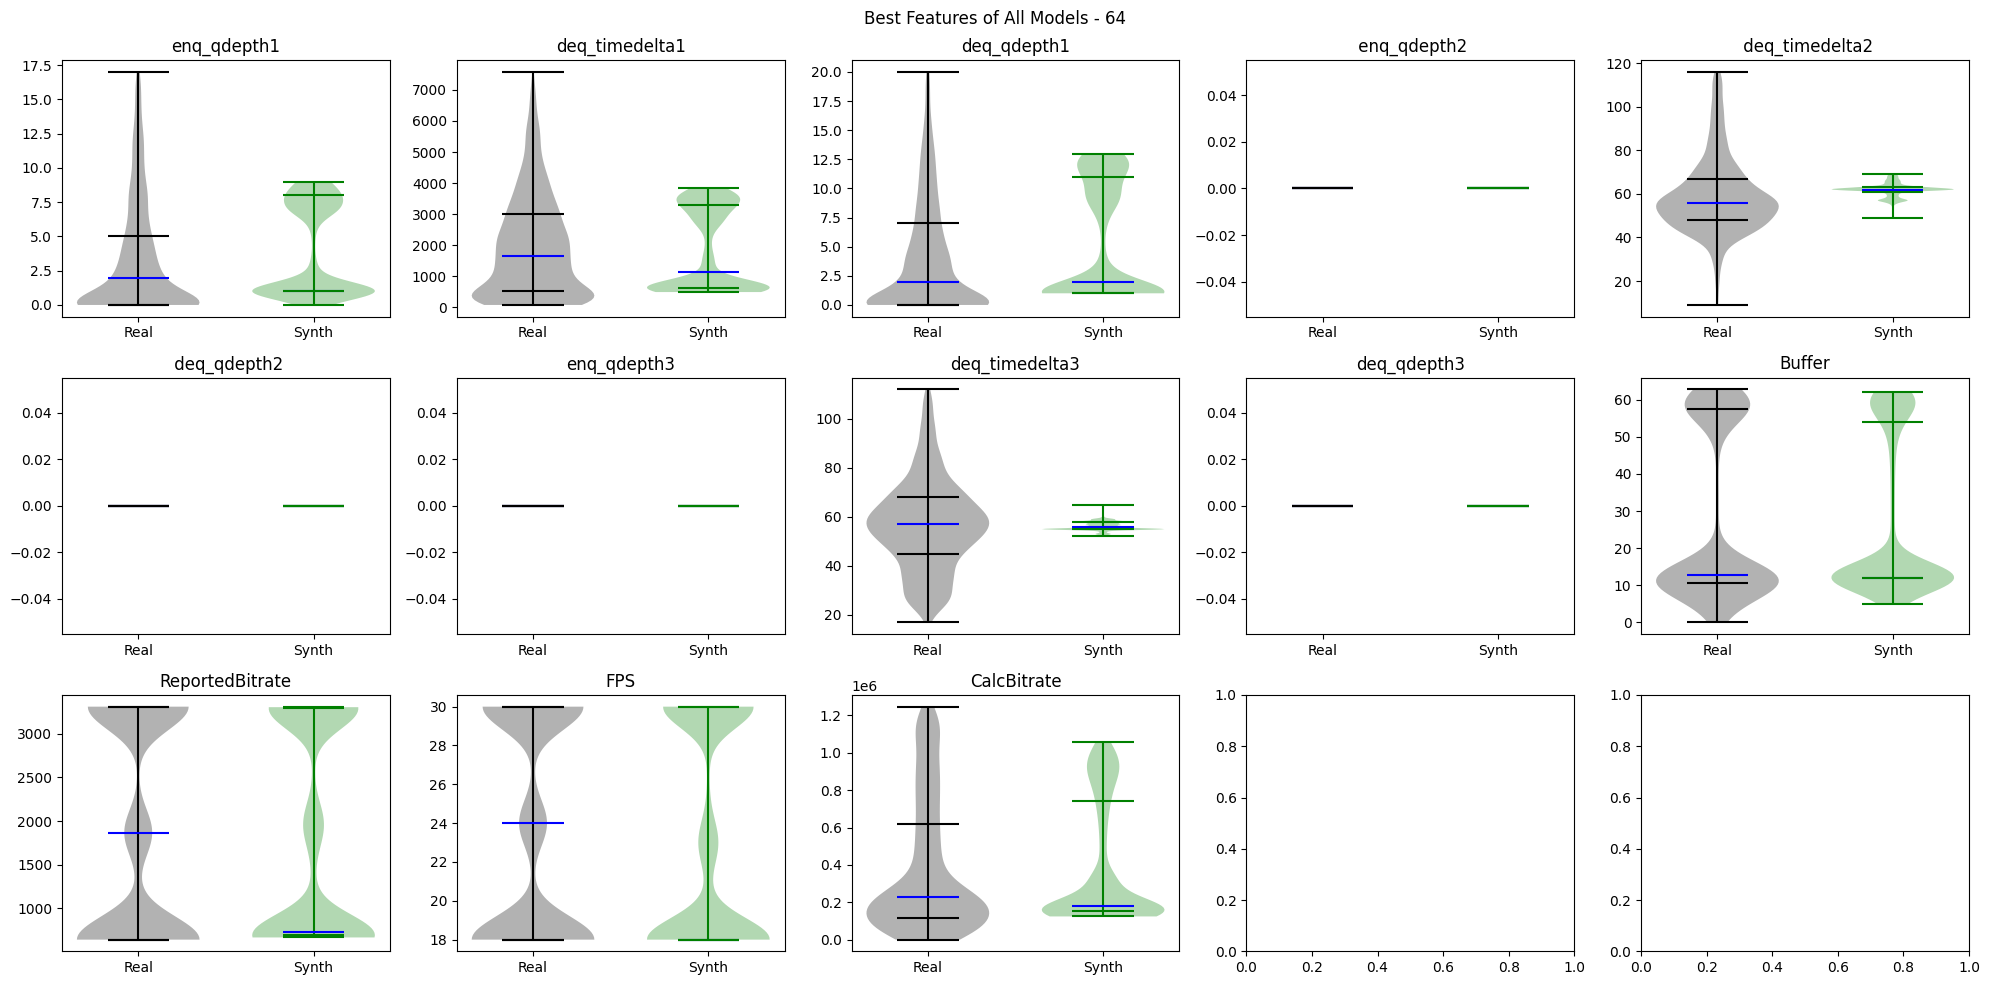

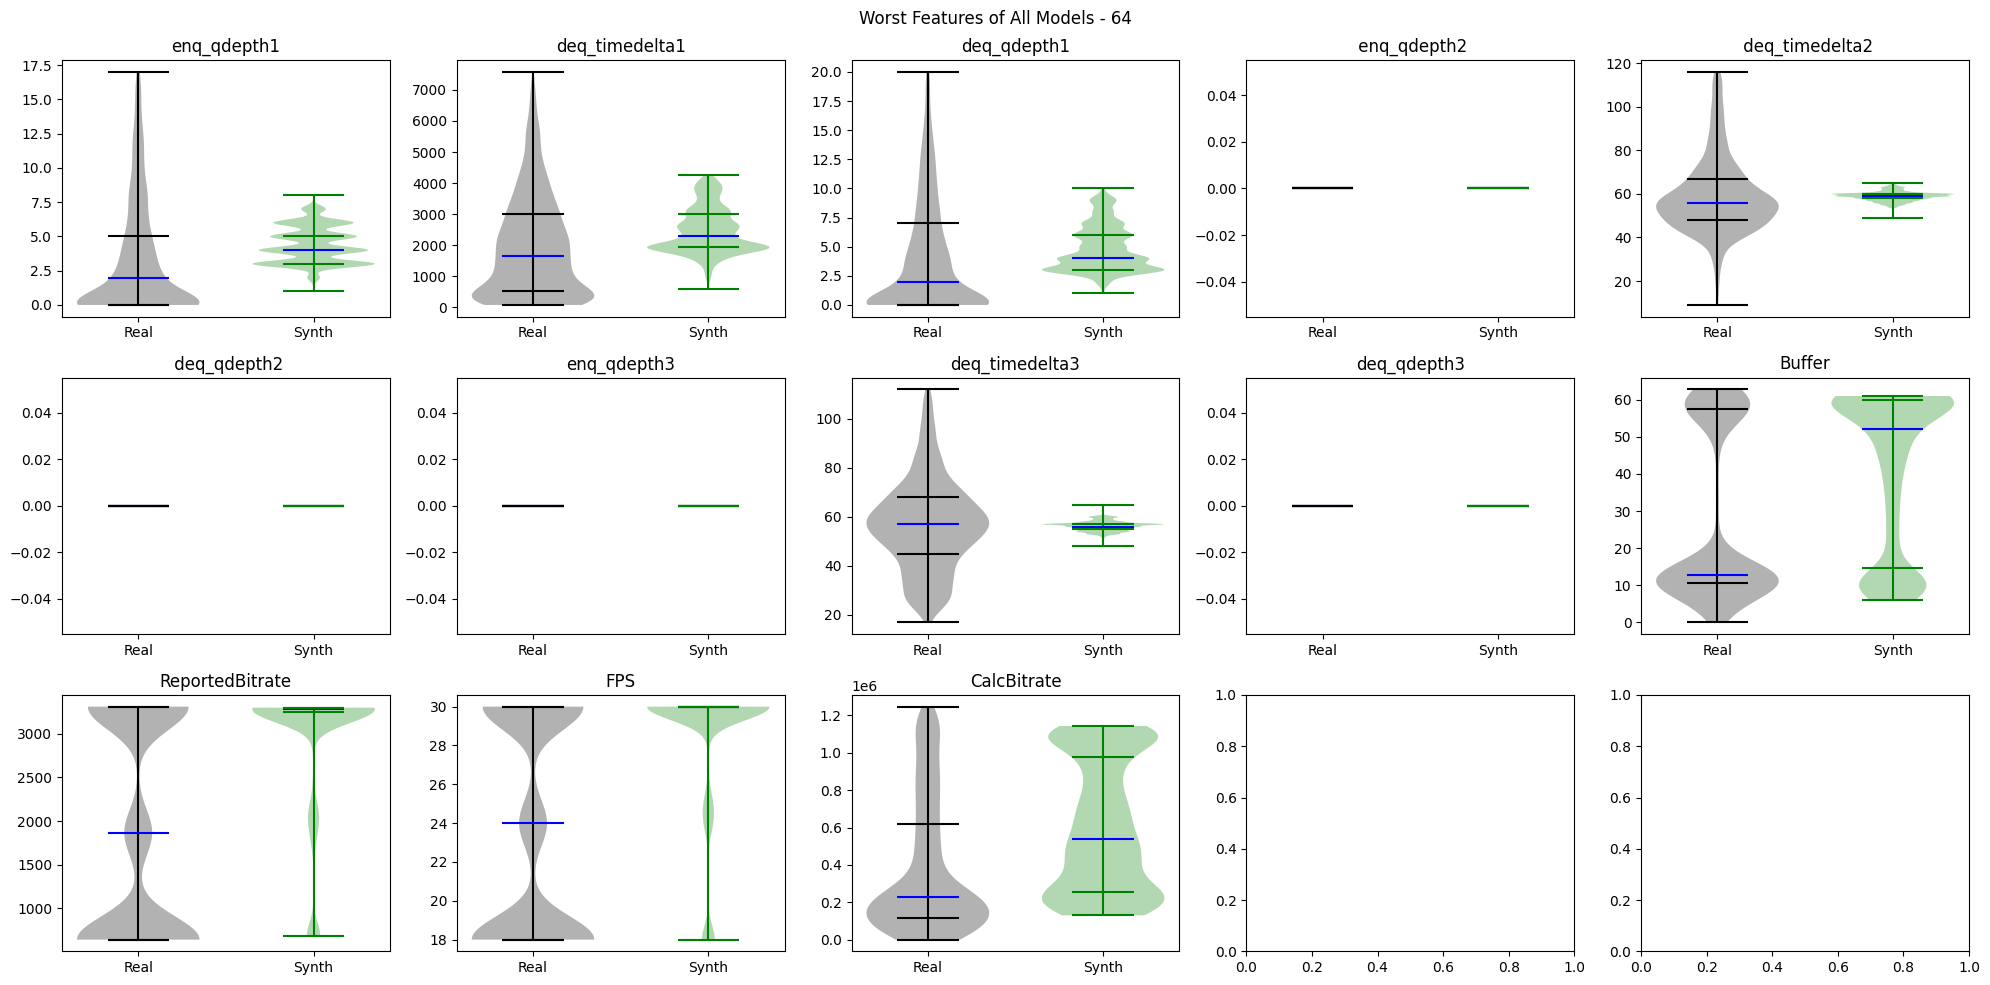

In [27]:
genViolinAllFeatures(models_obj, 'Best Features of All Models - 32', real_32, best_modelsum_32, sample_size, num_cols, save=True, file_name='32_best_models_sum')
genViolinAllFeatures(models_obj, 'Worst Features of All Models - 32', real_32, worst_modelsum_32, sample_size, num_cols, save=True, file_name='32_worst_models_sum')
genViolinAllFeatures(models_obj, 'Best Features of All Models - 64', real_64, best_modelsum_64, sample_size, num_cols, save=True, file_name='64_best_models_sum')
genViolinAllFeatures(models_obj, 'Worst Features of All Models - 64', real_64, worst_modelsum_64, sample_size, num_cols, save=True, file_name='64_worst_models_sum')

############ SAVE GRAPHS AND PLOTS ############

In [48]:
genBestWorstCDFSeparate(models_obj, 'best_worst_model_sum', real_32, best_modelsum_32, worst_modelsum_32, sample_size, num_cols, clas=32, save=True, show=False)
genBestWorstCDFSeparate(models_obj, 'best_worst_model_sum', real_64, best_modelsum_64, worst_modelsum_64, sample_size, num_cols, clas=64, save=True, show=False)

In [49]:
genBestWorstEMASeparate(models_obj, 'best_worst_model_sum', real_32, best_modelsum_32, worst_modelsum_32, 30, sample_size, num_cols, clas=32, save=True, show=False)
genBestWorstEMASeparate(models_obj, 'best_worst_model_sum', real_64, best_modelsum_64, worst_modelsum_64, 30, sample_size, num_cols, clas=64, save=True, show=False)

In [50]:
genViolinBestWorstSeparate32_64(models_obj, 'best_worst_model_sum', real_32, best_modelsum_32, worst_modelsum_32, 32, sample_size, num_cols, save=True, show=False)
genViolinBestWorstSeparate32_64(models_obj, 'best_worst_model_sum', real_64, best_modelsum_64, worst_modelsum_64, 64, sample_size, num_cols, save=True, show=False)

In [51]:
genBoxPlotModelsSeparate(models_obj, 'best_model_sum', real_32, best_modelsum_32, real_64, best_modelsum_64, sample_size, num_cols, save=True, show=False)

In [19]:
ds_best_modelsum_32 = createSaveDataSetModel(models_obj, 'best_modelsum_32', best_modelsum_32, num_cols, True)
ds_best_modelsum_64 = createSaveDataSetModel(models_obj, 'best_modelsum_64', best_modelsum_64, num_cols, True)
ds_worst_modelsum_32 = createSaveDataSetModel(models_obj, 'worst_modelsum_32', worst_modelsum_32, num_cols, True)
ds_worst_modelsum_64 = createSaveDataSetModel(models_obj, 'worst_modelsum_64', worst_modelsum_64, num_cols, True)

In [17]:
ds_real_32 = createRealDataSet(models_obj, 'real_32', real_32, num_cols)
ds_real_64 = createRealDataSet(models_obj, 'real_64', real_64, num_cols)

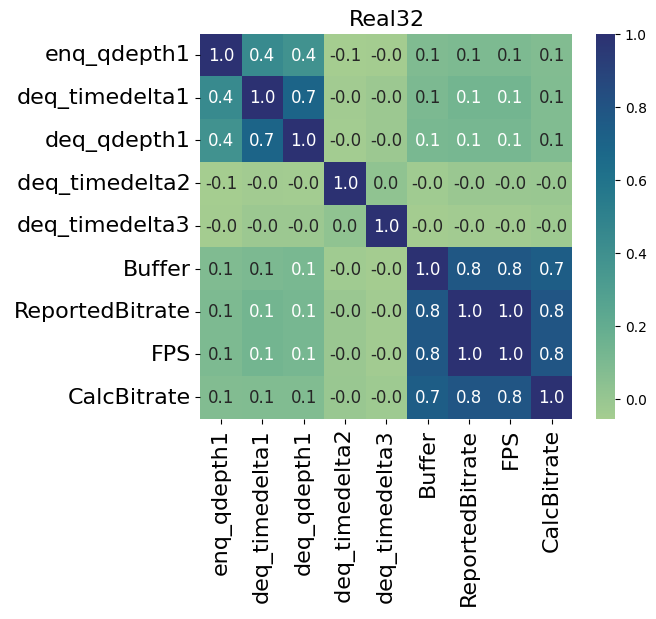

NameError: name 'ds_best_modelsum_32' is not defined

In [18]:
createCorrelationMatrix(models_obj, 'real32', 'Real32', ds_real_32 , 32, save=True)
createCorrelationMatrix(models_obj, 'bestmodel32', 'Best32', ds_best_modelsum_32, 32, save=True)
createCorrelationMatrix(models_obj, 'real64', 'Real64', ds_real_64, 64, save=True)
createCorrelationMatrix(models_obj, 'bestmodel64', 'Best64', ds_best_modelsum_64, 64, save=True)

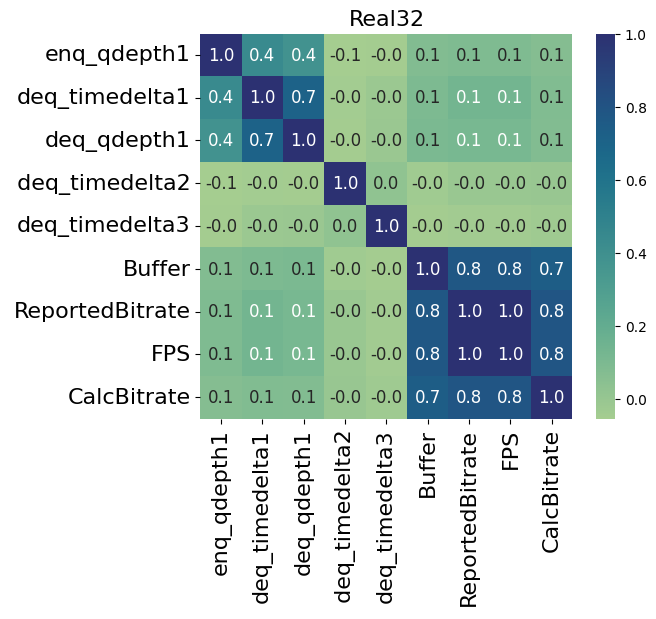

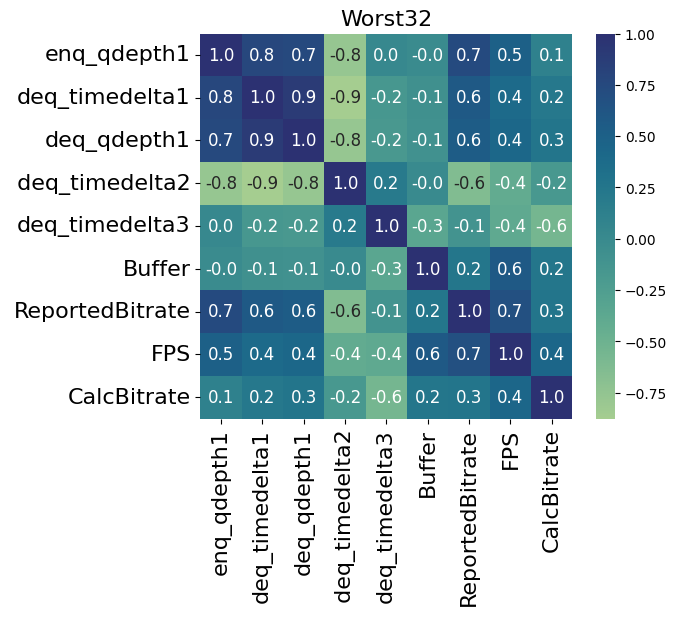

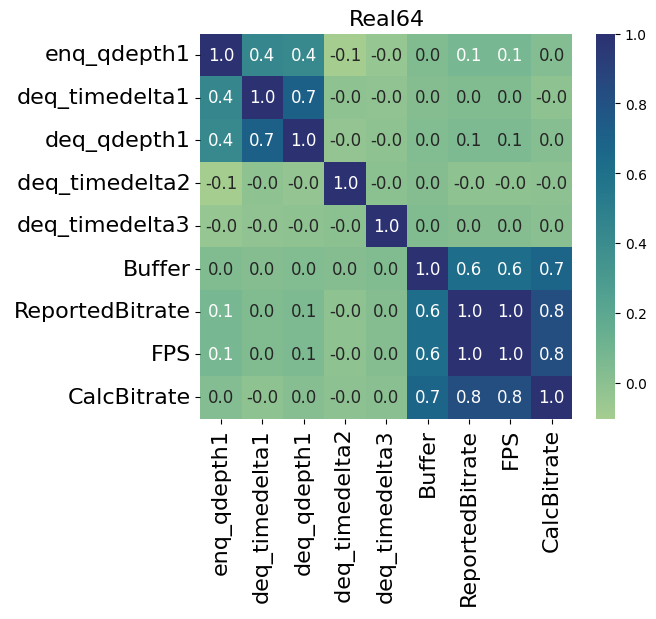

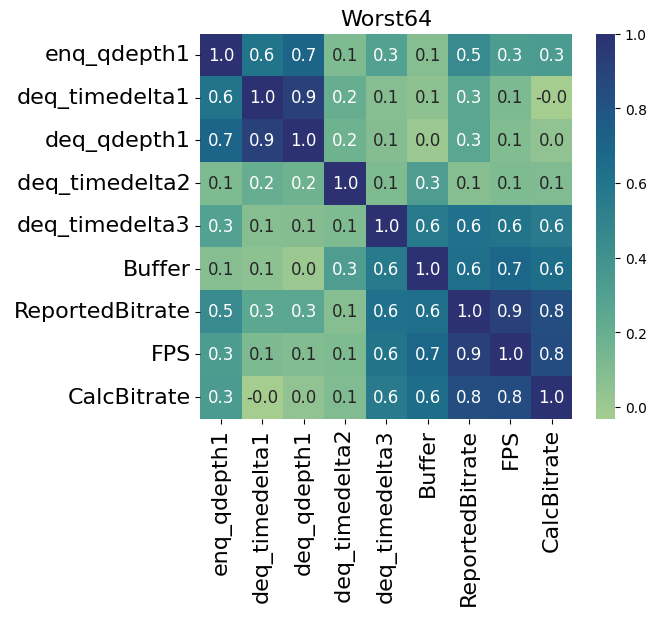

In [55]:
createCorrelationMatrix(models_obj, 'real32', 'Real32', ds_real_32 , 32, save=True)
createCorrelationMatrix(models_obj, 'worstmodel32', 'Worst32', ds_worst_modelsum_32, 32, save=True)
createCorrelationMatrix(models_obj, 'real64' , 'Real64',  ds_real_64, 64, save=True)
createCorrelationMatrix(models_obj, 'worstmodel64', 'Worst64', ds_worst_modelsum_64, 64, save=True)